In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import tqdm
import os
import time
import pickle
from tensorboardX import SummaryWriter

#from envs.burgers import Burgers
#from buffer import OfflineReplayBuffer
from critic import ValueLearner, QPiLearner, QSarsaLearner
from bppo import BehaviorCloning, BehaviorProximalPolicyOptimization
#from envs.burgers import Burgers

In [2]:
# Hyperparameters

# Experiment
env_name='burger'
path='logs'
log_freq=int(100)
seed=20241230
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

# For Value
v_steps=int(50000)
v_hidden_dim = 512
v_depth = 3
v_lr = 1e-4
v_batch_size = 64

# For Q
q_bc_steps=int(50000)
q_pi_steps=10 # Number of steps to update Q-network in each iteration. Only used if is_offpolicy_update=True.
q_hidden_dim = 512
q_depth = 3
q_lr = 1e-4
q_batch_size = 64
target_update_freq=2
tau=0.005 # Soft update rate for target Q network parameters. See Q_learner.update()
gamma=0.99 # Discount factor for calculating the return.
is_offpolicy_update=False # Whether to use advantage replacement (as proposed in the BPPO paper) in Q-learning.
# If False, use Q-learning to update the Q-network parameters in each iteration.
# If True, only update the Q-network parameters once, and keep using this Q-network.

# For BC
bc_steps=int(50000)
bc_lr = 1e-4
bc_hidden_dim = 512
bc_depth = 3
bc_batch_size = 64

# For BPPO
bppo_steps=int(10000)
bppo_hidden_dim = 512
bppo_depth = 3
bppo_lr = 1e-4
bppo_batch_size = 64
clip_ratio=0.25 # PPO clip ratio. The probability ratio between new and old policy is clipped to be in the range [1-clip_ratio, 1+clip_ratio]
entropy_weight=0.00 # Weight of entropy loss in PPO and BPPO. Can be set to 0.01 for medium tasks.
decay=0.96 # Decay rate of PPO clip ratio
omega=0.9 # Related to setting the weight of advantage (see PPO code)
is_clip_decay=True # Whether to decay the clip_ratio during training
is_bppo_lr_decay=True # Whether to decay the learning rate of BPPO during trainining
is_update_old_policy=True # Whether to update the old policy of BPPO in each iteration. The old policy is used to calculate the probability ratio.
is_state_norm=False # Whether to normalize the states of the dataset.

# Other Settings
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device=torch.device('cpu')
state_dim = 128
action_dim = 128
x_range=(0,1)
nt=10000
dt=1e-4
nx=state_dim
dx=(x_range[1]-x_range[0])/nx
t_sample_interval=1000
nt1=nt//t_sample_interval

reward_ratio=0.1

In [3]:
from generate_burgers import load_burgers_data_sampled
from memory import ReplayMemory
'''
burgers_data_dict = load_burgers_data_sampled(
                x_range=x_range,
                nt = nt, # Number of time steps
                nx = state_dim, # Number of spatial nodes (grid points)
                dt= dt, # Temporal interval
                t_sample_interval=t_sample_interval, # The interval of time steps to generate a new control signal
                N = N, # Number of samples (trajectories) to generate
                )
'''
burgers_data_dict=pickle.load(open('data123\\burgers_2000_10_128_1735571539.pkl', 'rb'))
N=2000 # Number of trajectories to collect for offline dataset

print('Observations shape: ', burgers_data_dict['observations'].shape)
print('Next observations shape: ', burgers_data_dict['next_observations'].shape)
print('Actions shape: ', burgers_data_dict['actions'].shape)
print('Y_f shape: ', burgers_data_dict['Y_f'].shape)


state_trajectory=burgers_data_dict['observations'] # (N, nt1, state_dim)
action_trajectory=burgers_data_dict['actions'] # (N, nt1, action_dim)
final_state=burgers_data_dict['Y_f'] # (N, state_dim)
next_state_trajectory=burgers_data_dict['next_observations'] # (N, nt1, state_dim)

# Concatenate states, and compute rewards
concat_states=[]
concat_next_states=[]
rewards=[]
for n in range(N): # Loop over trajectories
    for t in range(nt1): # Loop over time steps
        concat_state = np.concatenate((state_trajectory[n, t], final_state[n], np.array([t])))
        concat_next_state = np.concatenate((next_state_trajectory[n, t], final_state[n], np.array([t])))
        state_reward = -((state_trajectory[n, t]-final_state[n])**2).mean()
        action_reward = -np.sum(action_trajectory[n, t]**2)
        reward = state_reward + reward_ratio*action_reward
        concat_states.append(concat_state)
        concat_next_states.append(concat_next_state)
        rewards.append(reward)
concat_states=np.array(concat_states) # (N*nt1, state_dim*2+1)
concat_next_states=np.array(concat_next_states) # (N*nt1, state_dim*2+1)
rewards=np.array(rewards) # (N*nt1,)
print('Concatenated states shape: ', concat_states.shape)
print('rewards shape: ', rewards.shape)

memory_data_dict={}
memory_data_dict['observations']=torch.tensor(concat_states, dtype=torch.float32)
memory_data_dict['actions']=torch.tensor(action_trajectory, dtype=torch.float32).reshape(N*nt1, action_dim)
memory_data_dict['rewards']=torch.tensor(rewards, dtype=torch.float32)
memory_data_dict['next_observations']=torch.tensor(concat_next_states, dtype=torch.float32)
memory_data_dict['timeouts']=torch.zeros(N*nt1, dtype=torch.int) # Placeholder, not used
memory_data_dict['terminals']=torch.zeros(N*nt1, dtype=torch.int) # Placeholder, not used

memory = ReplayMemory(max_size=1000000)
memory.load_dataset(data_dict=memory_data_dict)


Observations shape:  (2000, 10, 128)
Next observations shape:  (2000, 10, 128)
Actions shape:  (2000, 10, 128)
Y_f shape:  (2000, 128)
Concatenated states shape:  (20000, 257)
rewards shape:  (20000,)

Replay Memory loaded with size: 20000
states shape: torch.Size([20000, 257])
actions shape: torch.Size([20000, 128])
rewards shape: torch.Size([20000])
next_states shape: torch.Size([20000, 257])


In [4]:
# summarywriter logger
current_time = time.strftime("%Y_%m_%d__%H_%M_%S", time.localtime())
path = os.path.join(path, str(seed))
os.makedirs(os.path.join(path, current_time))
print(f'Made log directory at {os.path.join(path, current_time)}')

logger_path = os.path.join(path, current_time)
logger = SummaryWriter(log_dir=logger_path, comment='')

Made log directory at logs\20241230\2024_12_31__01_01_11


In [5]:
# initilize
value = ValueLearner(device=device,
                        state_dim=2*state_dim+1,
                        hidden_dim=v_hidden_dim,
                        depth=v_depth,
                        value_lr=v_lr,
                        batch_size=v_batch_size)

Q_bc = QSarsaLearner(device=device,
                        state_dim=2*state_dim+1,
                        action_dim=action_dim,
                        hidden_dim=q_hidden_dim, depth=q_depth,
                        Q_lr=q_lr,
                        target_update_freq=target_update_freq,
                        tau=tau,
                        gamma=gamma,
                        batch_size=q_batch_size)
#if is_offpolicy_update: 
#    Q_pi=QPiLearner(device=device,
#                        state_dim=2*state_dim+1,
#                        action_dim=action_dim,
#                        hidden_dim=q_hidden_dim,
#                        depth=q_depth,
#                        Q_lr=q_lr,
#                        target_update_freq=target_update_freq,
#                        tau=tau,
#                        gamma=gamma,
#                        batch_size=q_batch_size)
bc=BehaviorCloning(device=device,
                        state_dim=2*state_dim+1,
                        hidden_dim=bc_hidden_dim,
                        depth=bc_depth,
                        action_dim=action_dim,
                        policy_lr=bc_lr,
                        batch_size=bc_batch_size)
bppo=BehaviorProximalPolicyOptimization(device=device,
                        state_dim=2*state_dim+1,
                        hidden_dim=bppo_hidden_dim,
                        depth=bppo_depth,
                        action_dim=action_dim,
                        policy_lr=bppo_lr,
                        clip_ratio=clip_ratio,
                        entropy_weight=entropy_weight,
                        decay=decay,
                        omega=omega,
                        batch_size=bppo_batch_size)

In [6]:
# value training
value_path = os.path.join(path, 'value.pt')
if os.path.exists(value_path):
    value.load(value_path)
else:
    for step in tqdm.tqdm(range(int(v_steps)), desc='value updating ......'):
        value_loss = value.update(memory)
        
        if step % int(log_freq) == 0:
            print(f"Step: {step}, Loss: {value_loss:.6f}")
            logger.add_scalar('value_loss', value_loss, global_step=(step+1))
    value.save(value_path)

# Q_bc training
Q_bc_path = os.path.join(path, 'Q_bc.pt')
if os.path.exists(Q_bc_path):
    Q_bc.load(Q_bc_path)
else:
    for step in tqdm.tqdm(range(int(q_bc_steps)), desc='Q_bc updating ......'):
        Q_bc_loss = Q_bc.update(memory, pi=None)
        if step % int(log_freq) == 0:
            print(f"Step: {step}, Loss: {Q_bc_loss:.6f}")
            logger.add_scalar('Q_bc_loss', Q_bc_loss, global_step=(step+1))
    Q_bc.save(Q_bc_path)

#if is_offpolicy_update:
#    Q_pi.load(Q_bc_path)



Value parameters loaded
Q function parameters loaded


e:\PythonProjects\BPPO_custom_\critic.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self._value.load_state_dict(torch.load(path, map_location=self._device))
e:\Python

In [7]:
mean, std = 0., 1.

# bc training
best_bc_path = os.path.join(path, 'bc_best.pt')
if os.path.exists(best_bc_path):
    bc.load(best_bc_path)
else:
    #best_bc_score = 0
    for step in tqdm.tqdm(range(int(bc_steps)), desc='bc updating ......'):
        bc_loss = bc.update(memory)
        if step % int(log_freq) == 0:
        #    current_bc_score = bc.offline_evaluate(env, seed)
        #    if current_bc_score > best_bc_score:
        #        best_bc_score = current_bc_score
        #        bc.save(best_bc_path)
        #        np.savetxt(os.path.join(path, 'best_bc.csv'), [best_bc_score], fmt='%f', delimiter=',')
        #    print(f"Step: {step}, Loss: {bc_loss:.4f}, Score: {current_bc_score:.4f}")
            print(f"Step: {step}, Loss: {bc_loss:.4f}")
            logger.add_scalar('bc_loss', bc_loss, global_step=(step+1))
        #    logger.add_scalar('bc_score', current_bc_score, global_step=(step+1))
    bc.save(os.path.join(path, 'bc_best.pt'))
    bc.load(best_bc_path)



Behavior policy parameters loaded


e:\PythonProjects\BPPO_custom_\bppo.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self._policy.load_state_dict(torch.load(path, map_location=self._device))


In [10]:
# bppo training
bppo.load(best_bc_path)
best_bppo_path = os.path.join(path, current_time, 'bppo_best.pt')
Q = Q_bc # If advantage replacement, then Q_{\pi k}=Q_{\pi\beta}
#best_bppo_score = bppo.offline_evaluate(env, seed, eval_episodes=10)
#print('best_bppo_score:',best_bppo_score,'-------------------------')
for step in tqdm.tqdm(range(int(bppo_steps)), desc='bppo updating ......'):
    if step > 200:
        is_clip_decay = False
        is_bppo_lr_decay = False
    bppo_loss = bppo.update(memory, Q, value, is_clip_decay, is_bppo_lr_decay)
    #current_bppo_score = bppo.offline_evaluate(env, seed, eval_episodes=10) # J_{\pi k}
    #if current_bppo_score > best_bppo_score:
    #    best_bppo_score = current_bppo_score
    #    print('best_bppo_score:',best_bppo_score,'-------------------------')
    #    bppo.save(best_bppo_path)
    #    np.savetxt(os.path.join(path, current_time, 'best_bppo.csv'), [best_bppo_score], fmt='%f', delimiter=',')
    #    if is_update_old_policy:
    #        bppo.set_old_policy() # Set the old policy to the current policy
    #if is_offpolicy_update: # If not using advantage replacement, calculate Q_{\pi k} by Q-learning
    #    for _ in tqdm(range(int(q_pi_steps)), desc='Q_pi updating ......'): 
    #        Q_pi_loss = Q_pi.update(replay_buffer, bppo)
    #    Q = Q_pi
    if step % 10 == 0:
        print(f"Epoch: {step+1}, Loss: {bppo_loss:.4f}")
    logger.add_scalar('bppo_loss', bppo_loss, global_step=(step+1))
    #logger.add_scalar('bppo_score', current_bppo_score, global_step=(step+1))

logger.close()

e:\PythonProjects\BPPO_custom_\bppo.py:232: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self._policy.load_state_dict(torch.load(path, map_location=self._device))


Policy parameters loaded


bppo updating ......:   0%|          | 4/10000 [00:00<04:11, 39.72it/s]

Epoch: 1, Loss: -0.1520


bppo updating ......:   0%|          | 10/10000 [00:00<03:37, 45.87it/s]

Epoch: 11, Loss: -0.0564


bppo updating ......:   0%|          | 27/10000 [00:00<03:20, 49.83it/s]

Epoch: 21, Loss: 0.0044
Epoch: 31, Loss: -0.0037


bppo updating ......:   1%|          | 51/10000 [00:01<03:10, 52.34it/s]

Epoch: 41, Loss: 0.0134
Epoch: 51, Loss: 0.0121


bppo updating ......:   1%|          | 68/10000 [00:01<03:27, 47.76it/s]

Epoch: 61, Loss: -0.0038


bppo updating ......:   1%|          | 80/10000 [00:01<03:19, 49.75it/s]

Epoch: 71, Loss: -0.0084


bppo updating ......:   1%|          | 85/10000 [00:01<03:37, 45.64it/s]

Epoch: 81, Loss: 0.0085


bppo updating ......:   1%|          | 95/10000 [00:01<03:37, 45.64it/s]

Epoch: 91, Loss: 0.0015


bppo updating ......:   1%|          | 105/10000 [00:02<03:53, 42.39it/s]

Epoch: 101, Loss: -0.0029


bppo updating ......:   1%|          | 120/10000 [00:02<03:40, 44.75it/s]

Epoch: 111, Loss: 0.0014


bppo updating ......:   1%|▏         | 125/10000 [00:02<03:43, 44.12it/s]

Epoch: 121, Loss: -0.0169


bppo updating ......:   1%|▏         | 135/10000 [00:02<03:43, 44.12it/s]

Epoch: 131, Loss: 0.0213


bppo updating ......:   1%|▏         | 145/10000 [00:03<03:45, 43.71it/s]

Epoch: 141, Loss: -0.0002


bppo updating ......:   2%|▏         | 155/10000 [00:03<03:57, 41.53it/s]

Epoch: 151, Loss: -0.0084


bppo updating ......:   2%|▏         | 166/10000 [00:03<03:38, 45.02it/s]

Epoch: 161, Loss: 0.0002
Epoch: 171, Loss: 0.0141


bppo updating ......:   2%|▏         | 187/10000 [00:04<03:26, 47.43it/s]

Epoch: 181, Loss: 0.0201


bppo updating ......:   2%|▏         | 197/10000 [00:04<03:44, 43.65it/s]

Epoch: 191, Loss: -0.0132


bppo updating ......:   2%|▏         | 207/10000 [00:04<03:46, 43.33it/s]

Epoch: 201, Loss: 0.0124


bppo updating ......:   2%|▏         | 217/10000 [00:04<03:41, 44.24it/s]

Epoch: 211, Loss: 0.0242


bppo updating ......:   2%|▏         | 227/10000 [00:04<03:39, 44.60it/s]

Epoch: 221, Loss: 0.0252


bppo updating ......:   2%|▏         | 232/10000 [00:05<03:52, 42.02it/s]

Epoch: 231, Loss: 0.0126


bppo updating ......:   2%|▏         | 247/10000 [00:05<03:55, 41.48it/s]

Epoch: 241, Loss: 0.0097
Epoch: 251, Loss: 0.0103


bppo updating ......:   3%|▎         | 267/10000 [00:05<03:49, 42.48it/s]

Epoch: 261, Loss: 0.0014


bppo updating ......:   3%|▎         | 276/10000 [00:06<04:49, 33.56it/s]

Epoch: 271, Loss: -0.0034


bppo updating ......:   3%|▎         | 285/10000 [00:06<04:24, 36.67it/s]

Epoch: 281, Loss: -0.0031


bppo updating ......:   3%|▎         | 298/10000 [00:06<04:02, 39.93it/s]

Epoch: 291, Loss: -0.0016


bppo updating ......:   3%|▎         | 308/10000 [00:07<04:05, 39.47it/s]

Epoch: 301, Loss: -0.0094


bppo updating ......:   3%|▎         | 318/10000 [00:07<03:57, 40.72it/s]

Epoch: 311, Loss: 0.0003


bppo updating ......:   3%|▎         | 327/10000 [00:07<04:38, 34.70it/s]

Epoch: 321, Loss: 0.0001


bppo updating ......:   3%|▎         | 341/10000 [00:07<03:58, 40.51it/s]

Epoch: 331, Loss: -0.0105
Epoch: 341, Loss: 0.0014


bppo updating ......:   4%|▎         | 356/10000 [00:08<03:40, 43.71it/s]

Epoch: 351, Loss: 0.0024


bppo updating ......:   4%|▎         | 366/10000 [00:08<03:38, 44.17it/s]

Epoch: 361, Loss: -0.0132
Epoch: 371, Loss: 0.0406


bppo updating ......:   4%|▍         | 388/10000 [00:08<03:23, 47.33it/s]

Epoch: 381, Loss: 0.0107


bppo updating ......:   4%|▍         | 398/10000 [00:09<03:51, 41.44it/s]

Epoch: 391, Loss: 0.0154


bppo updating ......:   4%|▍         | 407/10000 [00:09<04:24, 36.21it/s]

Epoch: 401, Loss: 0.0016


bppo updating ......:   4%|▍         | 417/10000 [00:09<03:58, 40.23it/s]

Epoch: 411, Loss: 0.0005
Epoch: 421, Loss: 0.0417


bppo updating ......:   4%|▍         | 437/10000 [00:10<03:54, 40.87it/s]

Epoch: 431, Loss: 0.5282


bppo updating ......:   4%|▍         | 447/10000 [00:10<04:20, 36.70it/s]

Epoch: 441, Loss: 0.0669


bppo updating ......:   5%|▍         | 457/10000 [00:10<04:01, 39.50it/s]

Epoch: 451, Loss: 0.0128
Epoch: 461, Loss: 0.0008


bppo updating ......:   5%|▍         | 477/10000 [00:11<03:37, 43.84it/s]

Epoch: 471, Loss: -0.0037


bppo updating ......:   5%|▍         | 487/10000 [00:11<03:57, 40.14it/s]

Epoch: 481, Loss: 0.0025


bppo updating ......:   5%|▍         | 497/10000 [00:11<04:01, 39.38it/s]

Epoch: 491, Loss: 0.0069


bppo updating ......:   5%|▌         | 507/10000 [00:11<03:47, 41.81it/s]

Epoch: 501, Loss: 0.0028


bppo updating ......:   5%|▌         | 517/10000 [00:12<03:46, 41.83it/s]

Epoch: 511, Loss: -0.0027


bppo updating ......:   5%|▌         | 526/10000 [00:12<04:01, 39.30it/s]

Epoch: 521, Loss: 0.0297


bppo updating ......:   5%|▌         | 535/10000 [00:12<04:25, 35.64it/s]

Epoch: 531, Loss: -0.0030


bppo updating ......:   5%|▌         | 544/10000 [00:12<04:22, 36.09it/s]

Epoch: 541, Loss: 0.0233


bppo updating ......:   6%|▌         | 557/10000 [00:13<04:31, 34.81it/s]

Epoch: 551, Loss: 0.0187


bppo updating ......:   6%|▌         | 566/10000 [00:13<04:09, 37.80it/s]

Epoch: 561, Loss: 0.0146


bppo updating ......:   6%|▌         | 579/10000 [00:13<04:01, 38.93it/s]

Epoch: 571, Loss: 0.0113


bppo updating ......:   6%|▌         | 588/10000 [00:14<04:10, 37.53it/s]

Epoch: 581, Loss: 0.0222


bppo updating ......:   6%|▌         | 597/10000 [00:14<04:13, 37.16it/s]

Epoch: 591, Loss: 0.0296


bppo updating ......:   6%|▌         | 606/10000 [00:14<04:09, 37.61it/s]

Epoch: 601, Loss: -0.0054


bppo updating ......:   6%|▌         | 616/10000 [00:14<03:53, 40.14it/s]

Epoch: 611, Loss: 0.0002


bppo updating ......:   6%|▋         | 626/10000 [00:15<03:48, 41.09it/s]

Epoch: 621, Loss: 0.0003


bppo updating ......:   6%|▋         | 635/10000 [00:15<04:30, 34.65it/s]

Epoch: 631, Loss: 0.0159


bppo updating ......:   6%|▋         | 647/10000 [00:15<04:38, 33.56it/s]

Epoch: 641, Loss: 0.0021


bppo updating ......:   7%|▋         | 656/10000 [00:15<04:12, 37.06it/s]

Epoch: 651, Loss: 0.0931


bppo updating ......:   7%|▋         | 664/10000 [00:16<04:17, 36.22it/s]

Epoch: 661, Loss: -0.0003


bppo updating ......:   7%|▋         | 677/10000 [00:16<04:25, 35.09it/s]

Epoch: 671, Loss: 0.0025


bppo updating ......:   7%|▋         | 685/10000 [00:16<04:25, 35.09it/s]

Epoch: 681, Loss: -0.0045


bppo updating ......:   7%|▋         | 699/10000 [00:17<03:59, 38.87it/s]

Epoch: 691, Loss: -0.0080


bppo updating ......:   7%|▋         | 707/10000 [00:17<04:14, 36.50it/s]

Epoch: 701, Loss: 0.0046


bppo updating ......:   7%|▋         | 715/10000 [00:17<04:40, 33.15it/s]

Epoch: 711, Loss: 0.0121


bppo updating ......:   7%|▋         | 728/10000 [00:17<04:21, 35.45it/s]

Epoch: 721, Loss: -0.0038


bppo updating ......:   7%|▋         | 736/10000 [00:18<04:50, 31.85it/s]

Epoch: 731, Loss: 0.0180


bppo updating ......:   7%|▋         | 745/10000 [00:18<04:28, 34.45it/s]

Epoch: 741, Loss: 0.0023


bppo updating ......:   8%|▊         | 758/10000 [00:18<04:16, 36.10it/s]

Epoch: 751, Loss: 0.0083


bppo updating ......:   8%|▊         | 766/10000 [00:19<04:32, 33.91it/s]

Epoch: 761, Loss: 0.0278


bppo updating ......:   8%|▊         | 779/10000 [00:19<04:20, 35.44it/s]

Epoch: 771, Loss: 0.2175


bppo updating ......:   8%|▊         | 788/10000 [00:19<04:07, 37.25it/s]

Epoch: 781, Loss: -0.0127


bppo updating ......:   8%|▊         | 798/10000 [00:19<03:49, 40.06it/s]

Epoch: 791, Loss: 0.0093


bppo updating ......:   8%|▊         | 808/10000 [00:20<03:49, 40.12it/s]

Epoch: 801, Loss: -0.0079


bppo updating ......:   8%|▊         | 817/10000 [00:20<04:10, 36.68it/s]

Epoch: 811, Loss: 0.0296


bppo updating ......:   8%|▊         | 825/10000 [00:20<04:24, 34.66it/s]

Epoch: 821, Loss: 0.0007


bppo updating ......:   8%|▊         | 839/10000 [00:21<04:22, 34.84it/s]

Epoch: 831, Loss: -0.0103


bppo updating ......:   8%|▊         | 847/10000 [00:21<04:25, 34.42it/s]

Epoch: 841, Loss: -0.0158


bppo updating ......:   9%|▊         | 856/10000 [00:21<04:03, 37.62it/s]

Epoch: 851, Loss: 0.0230


bppo updating ......:   9%|▊         | 870/10000 [00:21<03:52, 39.29it/s]

Epoch: 861, Loss: -0.0040


bppo updating ......:   9%|▊         | 874/10000 [00:22<04:26, 34.20it/s]

Epoch: 871, Loss: -0.0064


bppo updating ......:   9%|▉         | 888/10000 [00:22<03:54, 38.83it/s]

Epoch: 881, Loss: 0.0218
Epoch: 891, Loss: 0.0051


bppo updating ......:   9%|▉         | 908/10000 [00:22<03:34, 42.30it/s]

Epoch: 901, Loss: 0.0023


bppo updating ......:   9%|▉         | 918/10000 [00:23<03:48, 39.70it/s]

Epoch: 911, Loss: -0.0075


bppo updating ......:   9%|▉         | 926/10000 [00:23<04:11, 36.06it/s]

Epoch: 921, Loss: 0.0076


bppo updating ......:   9%|▉         | 935/10000 [00:23<04:08, 36.43it/s]

Epoch: 931, Loss: 0.0257


bppo updating ......:   9%|▉         | 949/10000 [00:24<03:52, 38.99it/s]

Epoch: 941, Loss: -0.0027


bppo updating ......:  10%|▉         | 957/10000 [00:24<04:14, 35.48it/s]

Epoch: 951, Loss: -0.0020


bppo updating ......:  10%|▉         | 970/10000 [00:24<03:55, 38.28it/s]

Epoch: 961, Loss: 0.4024


bppo updating ......:  10%|▉         | 975/10000 [00:24<03:45, 40.01it/s]

Epoch: 971, Loss: -0.0027


bppo updating ......:  10%|▉         | 990/10000 [00:25<03:33, 42.12it/s]

Epoch: 981, Loss: 0.0041


bppo updating ......:  10%|▉         | 995/10000 [00:25<04:21, 34.48it/s]

Epoch: 991, Loss: 0.0146


bppo updating ......:  10%|█         | 1009/10000 [00:25<03:43, 40.23it/s]

Epoch: 1001, Loss: -0.0133


bppo updating ......:  10%|█         | 1014/10000 [00:25<03:50, 38.90it/s]

Epoch: 1011, Loss: 0.0050


bppo updating ......:  10%|█         | 1029/10000 [00:26<04:00, 37.37it/s]

Epoch: 1021, Loss: 0.0066


bppo updating ......:  10%|█         | 1037/10000 [00:26<04:09, 35.86it/s]

Epoch: 1031, Loss: 0.0011


bppo updating ......:  10%|█         | 1047/10000 [00:26<03:46, 39.44it/s]

Epoch: 1041, Loss: 0.0021


bppo updating ......:  11%|█         | 1057/10000 [00:26<03:36, 41.34it/s]

Epoch: 1051, Loss: -0.0023


bppo updating ......:  11%|█         | 1067/10000 [00:27<03:30, 42.35it/s]

Epoch: 1061, Loss: -0.0020


bppo updating ......:  11%|█         | 1077/10000 [00:27<03:55, 37.93it/s]

Epoch: 1071, Loss: 0.0002


bppo updating ......:  11%|█         | 1087/10000 [00:27<03:40, 40.39it/s]

Epoch: 1081, Loss: 0.0067


bppo updating ......:  11%|█         | 1097/10000 [00:27<03:38, 40.66it/s]

Epoch: 1091, Loss: -0.0088


bppo updating ......:  11%|█         | 1107/10000 [00:28<03:39, 40.46it/s]

Epoch: 1101, Loss: 0.0029


bppo updating ......:  11%|█         | 1116/10000 [00:28<03:56, 37.54it/s]

Epoch: 1111, Loss: -0.0018


bppo updating ......:  11%|█         | 1124/10000 [00:28<04:21, 33.93it/s]

Epoch: 1121, Loss: -0.0019


bppo updating ......:  11%|█▏        | 1138/10000 [00:28<03:40, 40.13it/s]

Epoch: 1131, Loss: -0.0055


bppo updating ......:  11%|█▏        | 1148/10000 [00:29<03:39, 40.29it/s]

Epoch: 1141, Loss: 0.0032


bppo updating ......:  12%|█▏        | 1158/10000 [00:29<03:39, 40.23it/s]

Epoch: 1151, Loss: 0.0007


bppo updating ......:  12%|█▏        | 1168/10000 [00:29<03:38, 40.49it/s]

Epoch: 1161, Loss: -0.0162


bppo updating ......:  12%|█▏        | 1177/10000 [00:29<04:07, 35.59it/s]

Epoch: 1171, Loss: 0.0145


bppo updating ......:  12%|█▏        | 1185/10000 [00:30<04:00, 36.72it/s]

Epoch: 1181, Loss: 0.0144


bppo updating ......:  12%|█▏        | 1198/10000 [00:30<03:39, 40.04it/s]

Epoch: 1191, Loss: -0.0155


bppo updating ......:  12%|█▏        | 1208/10000 [00:30<03:30, 41.85it/s]

Epoch: 1201, Loss: 0.0007


bppo updating ......:  12%|█▏        | 1218/10000 [00:30<03:29, 41.97it/s]

Epoch: 1211, Loss: -0.0043


bppo updating ......:  12%|█▏        | 1228/10000 [00:31<03:34, 40.82it/s]

Epoch: 1221, Loss: -0.0059


bppo updating ......:  12%|█▏        | 1238/10000 [00:31<03:44, 39.09it/s]

Epoch: 1231, Loss: -0.0006


bppo updating ......:  12%|█▏        | 1246/10000 [00:31<04:02, 36.10it/s]

Epoch: 1241, Loss: -0.0037


bppo updating ......:  13%|█▎        | 1256/10000 [00:31<03:38, 39.96it/s]

Epoch: 1251, Loss: 0.0083
Epoch: 1261, Loss: -0.0041


bppo updating ......:  13%|█▎        | 1276/10000 [00:32<03:22, 43.03it/s]

Epoch: 1271, Loss: -0.0003


bppo updating ......:  13%|█▎        | 1286/10000 [00:32<03:20, 43.53it/s]

Epoch: 1281, Loss: 0.0190


bppo updating ......:  13%|█▎        | 1296/10000 [00:32<03:21, 43.25it/s]

Epoch: 1291, Loss: -0.0117


bppo updating ......:  13%|█▎        | 1306/10000 [00:33<03:52, 37.35it/s]

Epoch: 1301, Loss: 0.0077


bppo updating ......:  13%|█▎        | 1314/10000 [00:33<03:52, 37.30it/s]

Epoch: 1311, Loss: -0.0062


bppo updating ......:  13%|█▎        | 1327/10000 [00:33<03:55, 36.75it/s]

Epoch: 1321, Loss: -0.0163


bppo updating ......:  13%|█▎        | 1334/10000 [00:34<07:05, 20.39it/s]

Epoch: 1331, Loss: -0.0287


bppo updating ......:  13%|█▎        | 1343/10000 [00:34<08:07, 17.75it/s]

Epoch: 1341, Loss: -0.0070


bppo updating ......:  14%|█▎        | 1356/10000 [00:35<07:14, 19.88it/s]

Epoch: 1351, Loss: -0.0018


bppo updating ......:  14%|█▎        | 1366/10000 [00:35<05:51, 24.54it/s]

Epoch: 1361, Loss: -0.0147


bppo updating ......:  14%|█▎        | 1373/10000 [00:36<05:25, 26.54it/s]

Epoch: 1371, Loss: 0.0052


bppo updating ......:  14%|█▍        | 1386/10000 [00:36<06:09, 23.32it/s]

Epoch: 1381, Loss: -0.0045


bppo updating ......:  14%|█▍        | 1392/10000 [00:37<06:58, 20.59it/s]

Epoch: 1391, Loss: 0.0024


bppo updating ......:  14%|█▍        | 1405/10000 [00:37<05:56, 24.14it/s]

Epoch: 1401, Loss: -0.0099


bppo updating ......:  14%|█▍        | 1415/10000 [00:38<05:01, 28.44it/s]

Epoch: 1411, Loss: -0.0050


bppo updating ......:  14%|█▍        | 1425/10000 [00:38<04:49, 29.58it/s]

Epoch: 1421, Loss: 0.0000


bppo updating ......:  14%|█▍        | 1437/10000 [00:38<05:02, 28.34it/s]

Epoch: 1431, Loss: 0.0091


bppo updating ......:  14%|█▍        | 1444/10000 [00:39<05:18, 26.86it/s]

Epoch: 1441, Loss: -0.0045


bppo updating ......:  15%|█▍        | 1457/10000 [00:39<04:55, 28.93it/s]

Epoch: 1451, Loss: -0.0022


bppo updating ......:  15%|█▍        | 1466/10000 [00:39<05:29, 25.89it/s]

Epoch: 1461, Loss: 0.0093


bppo updating ......:  15%|█▍        | 1476/10000 [00:40<05:58, 23.80it/s]

Epoch: 1471, Loss: -0.0058


bppo updating ......:  15%|█▍        | 1483/10000 [00:40<05:31, 25.69it/s]

Epoch: 1481, Loss: 0.0129


bppo updating ......:  15%|█▍        | 1493/10000 [00:41<11:01, 12.86it/s]

Epoch: 1491, Loss: 0.0139


bppo updating ......:  15%|█▌        | 1502/10000 [00:42<10:47, 13.13it/s]

Epoch: 1501, Loss: -0.0071


bppo updating ......:  15%|█▌        | 1519/10000 [00:43<05:26, 26.00it/s]

Epoch: 1511, Loss: -0.0118


bppo updating ......:  15%|█▌        | 1525/10000 [00:43<06:04, 23.25it/s]

Epoch: 1521, Loss: -0.0052


bppo updating ......:  15%|█▌        | 1531/10000 [00:43<07:12, 19.58it/s]

Epoch: 1531, Loss: -0.0035


bppo updating ......:  15%|█▌        | 1544/10000 [00:44<07:42, 18.30it/s]

Epoch: 1541, Loss: 0.0265


bppo updating ......:  16%|█▌        | 1554/10000 [00:44<05:44, 24.49it/s]

Epoch: 1551, Loss: 0.0004


bppo updating ......:  16%|█▌        | 1565/10000 [00:45<05:28, 25.69it/s]

Epoch: 1561, Loss: 0.0188


bppo updating ......:  16%|█▌        | 1576/10000 [00:45<04:49, 29.08it/s]

Epoch: 1571, Loss: 0.0168


bppo updating ......:  16%|█▌        | 1587/10000 [00:46<04:19, 32.36it/s]

Epoch: 1581, Loss: -0.0019


bppo updating ......:  16%|█▌        | 1595/10000 [00:46<04:20, 32.25it/s]

Epoch: 1591, Loss: 0.0139


bppo updating ......:  16%|█▌        | 1607/10000 [00:46<04:39, 30.03it/s]

Epoch: 1601, Loss: -0.0173


bppo updating ......:  16%|█▌        | 1615/10000 [00:47<04:31, 30.85it/s]

Epoch: 1611, Loss: 0.0157


bppo updating ......:  16%|█▌        | 1623/10000 [00:47<04:34, 30.53it/s]

Epoch: 1621, Loss: -0.0013


bppo updating ......:  16%|█▋        | 1634/10000 [00:47<05:37, 24.76it/s]

Epoch: 1631, Loss: 0.0048


bppo updating ......:  16%|█▋        | 1645/10000 [00:48<04:34, 30.45it/s]

Epoch: 1641, Loss: -0.0098


bppo updating ......:  17%|█▋        | 1653/10000 [00:48<04:34, 30.41it/s]

Epoch: 1651, Loss: -0.0004


bppo updating ......:  17%|█▋        | 1665/10000 [00:48<04:28, 31.02it/s]

Epoch: 1661, Loss: 0.0114


bppo updating ......:  17%|█▋        | 1676/10000 [00:49<04:43, 29.34it/s]

Epoch: 1671, Loss: 0.0024


bppo updating ......:  17%|█▋        | 1683/10000 [00:49<08:33, 16.19it/s]

Epoch: 1681, Loss: 0.0104


bppo updating ......:  17%|█▋        | 1696/10000 [00:51<09:57, 13.89it/s]

Epoch: 1691, Loss: 0.0123


bppo updating ......:  17%|█▋        | 1706/10000 [00:51<06:33, 21.09it/s]

Epoch: 1701, Loss: 0.0047


bppo updating ......:  17%|█▋        | 1716/10000 [00:52<06:47, 20.35it/s]

Epoch: 1711, Loss: 0.0019


bppo updating ......:  17%|█▋        | 1726/10000 [00:52<05:02, 27.33it/s]

Epoch: 1721, Loss: 0.0109


bppo updating ......:  17%|█▋        | 1739/10000 [00:52<04:00, 34.41it/s]

Epoch: 1731, Loss: -0.0001


bppo updating ......:  17%|█▋        | 1747/10000 [00:53<04:30, 30.54it/s]

Epoch: 1741, Loss: -0.0285


bppo updating ......:  18%|█▊        | 1754/10000 [00:53<04:57, 27.72it/s]

Epoch: 1751, Loss: 0.0427


bppo updating ......:  18%|█▊        | 1766/10000 [00:53<04:17, 31.98it/s]

Epoch: 1761, Loss: -0.0005


bppo updating ......:  18%|█▊        | 1778/10000 [00:53<03:48, 36.04it/s]

Epoch: 1771, Loss: 0.0075


bppo updating ......:  18%|█▊        | 1782/10000 [00:54<05:03, 27.04it/s]

Epoch: 1781, Loss: 0.0089


bppo updating ......:  18%|█▊        | 1794/10000 [00:54<04:54, 27.84it/s]

Epoch: 1791, Loss: 0.0051


bppo updating ......:  18%|█▊        | 1806/10000 [00:55<04:29, 30.39it/s]

Epoch: 1801, Loss: -0.0097


bppo updating ......:  18%|█▊        | 1819/10000 [00:55<03:46, 36.11it/s]

Epoch: 1811, Loss: -0.0158


bppo updating ......:  18%|█▊        | 1829/10000 [00:55<03:25, 39.67it/s]

Epoch: 1821, Loss: -0.0052


bppo updating ......:  18%|█▊        | 1834/10000 [00:55<03:22, 40.39it/s]

Epoch: 1831, Loss: 0.0014


bppo updating ......:  18%|█▊        | 1847/10000 [00:56<03:53, 34.93it/s]

Epoch: 1841, Loss: -0.0047


bppo updating ......:  19%|█▊        | 1855/10000 [00:56<03:50, 35.38it/s]

Epoch: 1851, Loss: -0.0056


bppo updating ......:  19%|█▊        | 1865/10000 [00:56<03:25, 39.63it/s]

Epoch: 1861, Loss: 0.0097


bppo updating ......:  19%|█▉        | 1875/10000 [00:56<03:13, 42.09it/s]

Epoch: 1871, Loss: -0.0078


bppo updating ......:  19%|█▉        | 1885/10000 [00:57<03:22, 40.16it/s]

Epoch: 1881, Loss: -0.0044


bppo updating ......:  19%|█▉        | 1895/10000 [00:57<03:44, 36.09it/s]

Epoch: 1891, Loss: -0.0172


bppo updating ......:  19%|█▉        | 1908/10000 [00:57<03:35, 37.53it/s]

Epoch: 1901, Loss: -0.0051


bppo updating ......:  19%|█▉        | 1916/10000 [00:57<04:01, 33.50it/s]

Epoch: 1911, Loss: -0.0085


bppo updating ......:  19%|█▉        | 1924/10000 [00:58<03:48, 35.42it/s]

Epoch: 1921, Loss: 0.0036


bppo updating ......:  19%|█▉        | 1937/10000 [00:58<03:38, 36.96it/s]

Epoch: 1931, Loss: 0.0141


bppo updating ......:  19%|█▉        | 1947/10000 [00:58<03:22, 39.71it/s]

Epoch: 1941, Loss: 0.0179


bppo updating ......:  20%|█▉        | 1957/10000 [00:58<03:18, 40.53it/s]

Epoch: 1951, Loss: 0.0052


bppo updating ......:  20%|█▉        | 1967/10000 [00:59<03:21, 39.91it/s]

Epoch: 1961, Loss: 0.0094


bppo updating ......:  20%|█▉        | 1977/10000 [00:59<03:35, 37.28it/s]

Epoch: 1971, Loss: -0.0234


bppo updating ......:  20%|█▉        | 1985/10000 [00:59<03:29, 38.27it/s]

Epoch: 1981, Loss: 0.0090


bppo updating ......:  20%|█▉        | 1997/10000 [01:00<03:47, 35.19it/s]

Epoch: 1991, Loss: -0.0033


bppo updating ......:  20%|██        | 2005/10000 [01:00<03:39, 36.46it/s]

Epoch: 2001, Loss: -0.0221


bppo updating ......:  20%|██        | 2014/10000 [01:00<04:16, 31.19it/s]

Epoch: 2011, Loss: -0.0070


bppo updating ......:  20%|██        | 2026/10000 [01:01<04:15, 31.16it/s]

Epoch: 2021, Loss: -0.0116


bppo updating ......:  20%|██        | 2033/10000 [01:01<06:39, 19.95it/s]

Epoch: 2031, Loss: -0.0004


bppo updating ......:  20%|██        | 2046/10000 [01:02<05:25, 24.47it/s]

Epoch: 2041, Loss: -0.0305


bppo updating ......:  21%|██        | 2056/10000 [01:02<04:55, 26.92it/s]

Epoch: 2051, Loss: 0.0117


bppo updating ......:  21%|██        | 2070/10000 [01:02<03:33, 37.15it/s]

Epoch: 2061, Loss: 0.0063


bppo updating ......:  21%|██        | 2075/10000 [01:02<03:26, 38.44it/s]

Epoch: 2071, Loss: 0.0571


bppo updating ......:  21%|██        | 2085/10000 [01:03<03:06, 42.33it/s]

Epoch: 2081, Loss: 0.0076


bppo updating ......:  21%|██        | 2095/10000 [01:03<03:05, 42.51it/s]

Epoch: 2091, Loss: -0.0031


bppo updating ......:  21%|██        | 2105/10000 [01:03<02:58, 44.26it/s]

Epoch: 2101, Loss: 0.0068


bppo updating ......:  21%|██        | 2115/10000 [01:03<03:06, 42.27it/s]

Epoch: 2111, Loss: -0.0166


bppo updating ......:  21%|██▏       | 2130/10000 [01:04<02:57, 44.36it/s]

Epoch: 2121, Loss: 0.0193


bppo updating ......:  21%|██▏       | 2135/10000 [01:04<02:59, 43.77it/s]

Epoch: 2131, Loss: 0.0012


bppo updating ......:  22%|██▏       | 2150/10000 [01:04<02:54, 45.10it/s]

Epoch: 2141, Loss: -0.0131


bppo updating ......:  22%|██▏       | 2155/10000 [01:04<02:53, 45.22it/s]

Epoch: 2151, Loss: 0.0723


bppo updating ......:  22%|██▏       | 2170/10000 [01:04<02:49, 46.15it/s]

Epoch: 2161, Loss: 0.0083


bppo updating ......:  22%|██▏       | 2175/10000 [01:05<03:02, 42.85it/s]

Epoch: 2171, Loss: 0.0034


bppo updating ......:  22%|██▏       | 2185/10000 [01:05<03:02, 42.81it/s]

Epoch: 2181, Loss: -0.0212


bppo updating ......:  22%|██▏       | 2200/10000 [01:05<02:53, 44.99it/s]

Epoch: 2191, Loss: -0.0009


bppo updating ......:  22%|██▏       | 2205/10000 [01:05<02:53, 44.87it/s]

Epoch: 2201, Loss: -0.0141


bppo updating ......:  22%|██▏       | 2215/10000 [01:06<02:53, 44.97it/s]

Epoch: 2211, Loss: -0.0010


bppo updating ......:  22%|██▏       | 2225/10000 [01:06<02:57, 43.86it/s]

Epoch: 2221, Loss: 0.0501


bppo updating ......:  22%|██▏       | 2235/10000 [01:06<03:08, 41.23it/s]

Epoch: 2231, Loss: 0.0082


bppo updating ......:  22%|██▎       | 2250/10000 [01:06<03:01, 42.72it/s]

Epoch: 2241, Loss: -0.0166


bppo updating ......:  23%|██▎       | 2255/10000 [01:06<03:18, 39.10it/s]

Epoch: 2251, Loss: -0.0078


bppo updating ......:  23%|██▎       | 2265/10000 [01:07<03:07, 41.31it/s]

Epoch: 2261, Loss: -0.0006


bppo updating ......:  23%|██▎       | 2280/10000 [01:07<02:53, 44.51it/s]

Epoch: 2271, Loss: 0.2651


bppo updating ......:  23%|██▎       | 2290/10000 [01:07<02:49, 45.43it/s]

Epoch: 2281, Loss: -0.0054


bppo updating ......:  23%|██▎       | 2295/10000 [01:07<02:48, 45.85it/s]

Epoch: 2291, Loss: -0.0131


bppo updating ......:  23%|██▎       | 2305/10000 [01:08<02:52, 44.56it/s]

Epoch: 2301, Loss: 0.0052


bppo updating ......:  23%|██▎       | 2318/10000 [01:08<04:03, 31.51it/s]

Epoch: 2311, Loss: -0.0022


bppo updating ......:  23%|██▎       | 2326/10000 [01:08<03:49, 33.44it/s]

Epoch: 2321, Loss: -0.0056


bppo updating ......:  23%|██▎       | 2334/10000 [01:09<03:39, 34.97it/s]

Epoch: 2331, Loss: -0.0065


bppo updating ......:  23%|██▎       | 2346/10000 [01:09<03:35, 35.44it/s]

Epoch: 2341, Loss: -0.0100


bppo updating ......:  24%|██▎       | 2354/10000 [01:09<04:43, 26.93it/s]

Epoch: 2351, Loss: 0.0226


bppo updating ......:  24%|██▎       | 2364/10000 [01:10<05:05, 24.96it/s]

Epoch: 2361, Loss: -0.0121


bppo updating ......:  24%|██▎       | 2373/10000 [01:10<07:00, 18.14it/s]

Epoch: 2371, Loss: 0.0053


bppo updating ......:  24%|██▍       | 2383/10000 [01:11<06:29, 19.54it/s]

Epoch: 2381, Loss: -0.0113


bppo updating ......:  24%|██▍       | 2394/10000 [01:12<07:54, 16.02it/s]

Epoch: 2391, Loss: 0.0025


bppo updating ......:  24%|██▍       | 2404/10000 [01:12<05:40, 22.33it/s]

Epoch: 2401, Loss: -0.0084


bppo updating ......:  24%|██▍       | 2415/10000 [01:12<04:51, 26.02it/s]

Epoch: 2411, Loss: -0.0121


bppo updating ......:  24%|██▍       | 2423/10000 [01:13<04:56, 25.56it/s]

Epoch: 2421, Loss: -0.0038


bppo updating ......:  24%|██▍       | 2435/10000 [01:13<05:31, 22.82it/s]

Epoch: 2431, Loss: 0.0100


bppo updating ......:  24%|██▍       | 2445/10000 [01:14<05:00, 25.16it/s]

Epoch: 2441, Loss: 0.0071


bppo updating ......:  25%|██▍       | 2455/10000 [01:14<04:42, 26.70it/s]

Epoch: 2451, Loss: 0.0608


bppo updating ......:  25%|██▍       | 2462/10000 [01:14<05:03, 24.81it/s]

Epoch: 2461, Loss: -0.0059


bppo updating ......:  25%|██▍       | 2475/10000 [01:15<04:51, 25.85it/s]

Epoch: 2471, Loss: 0.0032


bppo updating ......:  25%|██▍       | 2486/10000 [01:15<04:31, 27.70it/s]

Epoch: 2481, Loss: -0.0176


bppo updating ......:  25%|██▍       | 2494/10000 [01:16<04:00, 31.18it/s]

Epoch: 2491, Loss: 0.0023


bppo updating ......:  25%|██▌       | 2506/10000 [01:16<04:14, 29.44it/s]

Epoch: 2501, Loss: -0.0030


bppo updating ......:  25%|██▌       | 2516/10000 [01:16<05:12, 23.96it/s]

Epoch: 2511, Loss: 0.0091


bppo updating ......:  25%|██▌       | 2526/10000 [01:17<05:01, 24.76it/s]

Epoch: 2521, Loss: 0.0091


bppo updating ......:  25%|██▌       | 2536/10000 [01:17<04:16, 29.05it/s]

Epoch: 2531, Loss: -0.0131


bppo updating ......:  25%|██▌       | 2547/10000 [01:18<04:21, 28.52it/s]

Epoch: 2541, Loss: 0.0296


bppo updating ......:  26%|██▌       | 2553/10000 [01:18<05:15, 23.63it/s]

Epoch: 2551, Loss: -0.0047


bppo updating ......:  26%|██▌       | 2566/10000 [01:18<05:29, 22.53it/s]

Epoch: 2561, Loss: -0.0024


bppo updating ......:  26%|██▌       | 2576/10000 [01:19<04:47, 25.86it/s]

Epoch: 2571, Loss: -0.0011


bppo updating ......:  26%|██▌       | 2585/10000 [01:19<04:44, 26.05it/s]

Epoch: 2581, Loss: -0.0047


bppo updating ......:  26%|██▌       | 2595/10000 [01:20<04:41, 26.32it/s]

Epoch: 2591, Loss: 0.0121


bppo updating ......:  26%|██▌       | 2605/10000 [01:20<04:36, 26.78it/s]

Epoch: 2601, Loss: -0.0053


bppo updating ......:  26%|██▌       | 2617/10000 [01:20<04:00, 30.73it/s]

Epoch: 2611, Loss: -0.0087


bppo updating ......:  26%|██▋       | 2626/10000 [01:21<03:36, 34.10it/s]

Epoch: 2621, Loss: -0.0120


bppo updating ......:  26%|██▋       | 2634/10000 [01:21<03:57, 30.97it/s]

Epoch: 2631, Loss: -0.0059


bppo updating ......:  26%|██▋       | 2646/10000 [01:21<03:39, 33.47it/s]

Epoch: 2641, Loss: -0.0081


bppo updating ......:  27%|██▋       | 2654/10000 [01:21<03:38, 33.62it/s]

Epoch: 2651, Loss: 0.0000


bppo updating ......:  27%|██▋       | 2666/10000 [01:22<03:37, 33.73it/s]

Epoch: 2661, Loss: 0.0233


bppo updating ......:  27%|██▋       | 2679/10000 [01:22<03:25, 35.67it/s]

Epoch: 2671, Loss: -0.0089


bppo updating ......:  27%|██▋       | 2687/10000 [01:22<03:25, 35.66it/s]

Epoch: 2681, Loss: 0.0081


bppo updating ......:  27%|██▋       | 2695/10000 [01:23<03:42, 32.76it/s]

Epoch: 2691, Loss: 0.0070


bppo updating ......:  27%|██▋       | 2707/10000 [01:23<03:40, 33.02it/s]

Epoch: 2701, Loss: -0.0141


bppo updating ......:  27%|██▋       | 2715/10000 [01:23<03:37, 33.42it/s]

Epoch: 2711, Loss: -0.0058


bppo updating ......:  27%|██▋       | 2723/10000 [01:24<03:53, 31.19it/s]

Epoch: 2721, Loss: -0.0105


bppo updating ......:  27%|██▋       | 2734/10000 [01:24<04:19, 27.95it/s]

Epoch: 2731, Loss: 0.0003


bppo updating ......:  27%|██▋       | 2745/10000 [01:24<03:46, 32.05it/s]

Epoch: 2741, Loss: -0.0102


bppo updating ......:  28%|██▊       | 2754/10000 [01:25<03:27, 34.95it/s]

Epoch: 2751, Loss: -0.0100


bppo updating ......:  28%|██▊       | 2764/10000 [01:25<05:05, 23.68it/s]

Epoch: 2761, Loss: 0.0048


bppo updating ......:  28%|██▊       | 2775/10000 [01:25<04:23, 27.47it/s]

Epoch: 2771, Loss: 0.0228


bppo updating ......:  28%|██▊       | 2782/10000 [01:26<05:11, 23.19it/s]

Epoch: 2781, Loss: 0.0770


bppo updating ......:  28%|██▊       | 2798/10000 [01:26<03:46, 31.74it/s]

Epoch: 2791, Loss: 0.0081


bppo updating ......:  28%|██▊       | 2806/10000 [01:27<03:36, 33.16it/s]

Epoch: 2801, Loss: 0.0127


bppo updating ......:  28%|██▊       | 2814/10000 [01:27<04:27, 26.89it/s]

Epoch: 2811, Loss: 0.0130


bppo updating ......:  28%|██▊       | 2825/10000 [01:27<03:49, 31.21it/s]

Epoch: 2821, Loss: -0.0176


bppo updating ......:  28%|██▊       | 2837/10000 [01:28<03:24, 35.08it/s]

Epoch: 2831, Loss: -0.0130


bppo updating ......:  28%|██▊       | 2845/10000 [01:28<03:27, 34.40it/s]

Epoch: 2841, Loss: 0.0094


bppo updating ......:  29%|██▊       | 2858/10000 [01:28<03:10, 37.40it/s]

Epoch: 2851, Loss: 0.0153


bppo updating ......:  29%|██▊       | 2866/10000 [01:28<03:16, 36.38it/s]

Epoch: 2861, Loss: -0.0248


bppo updating ......:  29%|██▉       | 2878/10000 [01:29<03:15, 36.38it/s]

Epoch: 2871, Loss: -0.0248


bppo updating ......:  29%|██▉       | 2882/10000 [01:29<03:48, 31.19it/s]

Epoch: 2881, Loss: 0.0056


bppo updating ......:  29%|██▉       | 2897/10000 [01:29<03:48, 31.10it/s]

Epoch: 2891, Loss: 0.0057


bppo updating ......:  29%|██▉       | 2905/10000 [01:30<03:53, 30.34it/s]

Epoch: 2901, Loss: 0.0153


bppo updating ......:  29%|██▉       | 2917/10000 [01:30<03:39, 32.24it/s]

Epoch: 2911, Loss: 1.5186


bppo updating ......:  29%|██▉       | 2925/10000 [01:30<03:42, 31.86it/s]

Epoch: 2921, Loss: 0.0076


bppo updating ......:  29%|██▉       | 2937/10000 [01:31<03:27, 33.98it/s]

Epoch: 2931, Loss: 0.0170


bppo updating ......:  29%|██▉       | 2941/10000 [01:31<03:53, 30.24it/s]

Epoch: 2941, Loss: -0.0071


bppo updating ......:  30%|██▉       | 2955/10000 [01:31<03:54, 30.05it/s]

Epoch: 2951, Loss: -0.0259


bppo updating ......:  30%|██▉       | 2970/10000 [01:32<02:58, 39.31it/s]

Epoch: 2961, Loss: 0.0015


bppo updating ......:  30%|██▉       | 2975/10000 [01:32<02:55, 39.97it/s]

Epoch: 2971, Loss: -0.0206


bppo updating ......:  30%|██▉       | 2985/10000 [01:32<02:47, 41.99it/s]

Epoch: 2981, Loss: 0.0002


bppo updating ......:  30%|██▉       | 2995/10000 [01:32<02:50, 41.01it/s]

Epoch: 2991, Loss: -0.0022


bppo updating ......:  30%|███       | 3012/10000 [01:33<02:28, 46.99it/s]

Epoch: 3001, Loss: 0.0076
Epoch: 3011, Loss: 0.0014


bppo updating ......:  30%|███       | 3027/10000 [01:33<02:27, 47.35it/s]

Epoch: 3021, Loss: -0.0167
Epoch: 3031, Loss: 0.0043


bppo updating ......:  30%|███       | 3047/10000 [01:33<02:30, 46.12it/s]

Epoch: 3041, Loss: 0.0259
Epoch: 3051, Loss: -0.0025


bppo updating ......:  31%|███       | 3068/10000 [01:34<02:28, 46.76it/s]

Epoch: 3061, Loss: 0.0154


bppo updating ......:  31%|███       | 3078/10000 [01:34<02:27, 47.04it/s]

Epoch: 3071, Loss: -0.0078
Epoch: 3081, Loss: 0.0093


bppo updating ......:  31%|███       | 3099/10000 [01:34<02:38, 43.52it/s]

Epoch: 3091, Loss: -0.0033


bppo updating ......:  31%|███       | 3109/10000 [01:35<02:45, 41.72it/s]

Epoch: 3101, Loss: -0.0271


bppo updating ......:  31%|███       | 3119/10000 [01:35<02:40, 42.87it/s]

Epoch: 3111, Loss: -0.0070


bppo updating ......:  31%|███▏      | 3129/10000 [01:35<02:41, 42.49it/s]

Epoch: 3121, Loss: 0.0115


bppo updating ......:  31%|███▏      | 3134/10000 [01:35<02:55, 39.02it/s]

Epoch: 3131, Loss: -0.0178


bppo updating ......:  31%|███▏      | 3149/10000 [01:36<02:42, 42.26it/s]

Epoch: 3141, Loss: 0.0043


bppo updating ......:  32%|███▏      | 3159/10000 [01:36<02:46, 41.15it/s]

Epoch: 3151, Loss: 0.0062


bppo updating ......:  32%|███▏      | 3169/10000 [01:36<02:39, 42.79it/s]

Epoch: 3161, Loss: -0.0232


bppo updating ......:  32%|███▏      | 3179/10000 [01:36<02:30, 45.46it/s]

Epoch: 3171, Loss: 0.0167
Epoch: 3181, Loss: -0.0256


bppo updating ......:  32%|███▏      | 3199/10000 [01:37<02:28, 45.76it/s]

Epoch: 3191, Loss: -0.0077


bppo updating ......:  32%|███▏      | 3209/10000 [01:37<02:26, 46.24it/s]

Epoch: 3201, Loss: -0.0033


bppo updating ......:  32%|███▏      | 3219/10000 [01:37<02:25, 46.52it/s]

Epoch: 3211, Loss: -0.0059


bppo updating ......:  32%|███▏      | 3229/10000 [01:37<02:33, 44.18it/s]

Epoch: 3221, Loss: 0.0055


bppo updating ......:  32%|███▏      | 3239/10000 [01:38<02:29, 45.20it/s]

Epoch: 3231, Loss: 0.0064


bppo updating ......:  32%|███▏      | 3249/10000 [01:38<02:30, 44.80it/s]

Epoch: 3241, Loss: 0.0055


bppo updating ......:  33%|███▎      | 3259/10000 [01:38<02:26, 46.09it/s]

Epoch: 3251, Loss: -0.0132


bppo updating ......:  33%|███▎      | 3269/10000 [01:38<02:40, 42.03it/s]

Epoch: 3261, Loss: 0.0039


bppo updating ......:  33%|███▎      | 3274/10000 [01:39<02:49, 39.67it/s]

Epoch: 3271, Loss: -0.0146


bppo updating ......:  33%|███▎      | 3289/10000 [01:39<02:35, 43.14it/s]

Epoch: 3281, Loss: -0.0057


bppo updating ......:  33%|███▎      | 3299/10000 [01:39<02:26, 45.73it/s]

Epoch: 3291, Loss: -0.0143


bppo updating ......:  33%|███▎      | 3309/10000 [01:39<02:23, 46.53it/s]

Epoch: 3301, Loss: -0.0053
Epoch: 3311, Loss: -0.0113


bppo updating ......:  33%|███▎      | 3329/10000 [01:40<02:18, 48.00it/s]

Epoch: 3321, Loss: 0.0090


bppo updating ......:  33%|███▎      | 3339/10000 [01:40<02:20, 47.50it/s]

Epoch: 3331, Loss: 0.0112


bppo updating ......:  33%|███▎      | 3349/10000 [01:40<02:20, 47.21it/s]

Epoch: 3341, Loss: 0.0131


bppo updating ......:  34%|███▎      | 3359/10000 [01:40<02:28, 44.77it/s]

Epoch: 3351, Loss: -0.0053


bppo updating ......:  34%|███▎      | 3369/10000 [01:41<02:44, 40.22it/s]

Epoch: 3361, Loss: 0.0078


bppo updating ......:  34%|███▍      | 3379/10000 [01:41<02:41, 40.95it/s]

Epoch: 3371, Loss: 0.0030


bppo updating ......:  34%|███▍      | 3389/10000 [01:41<02:37, 41.88it/s]

Epoch: 3381, Loss: 0.0068


bppo updating ......:  34%|███▍      | 3399/10000 [01:41<02:26, 44.96it/s]

Epoch: 3391, Loss: -0.0216
Epoch: 3401, Loss: -0.0085


bppo updating ......:  34%|███▍      | 3414/10000 [01:42<02:35, 42.36it/s]

Epoch: 3411, Loss: -0.0174


bppo updating ......:  34%|███▍      | 3430/10000 [01:42<02:25, 45.31it/s]

Epoch: 3421, Loss: -0.0139
Epoch: 3431, Loss: -0.0082


bppo updating ......:  34%|███▍      | 3450/10000 [01:42<02:17, 47.49it/s]

Epoch: 3441, Loss: -0.0029


bppo updating ......:  35%|███▍      | 3455/10000 [01:43<02:21, 46.32it/s]

Epoch: 3451, Loss: 0.0057


bppo updating ......:  35%|███▍      | 3460/10000 [01:43<02:22, 45.90it/s]

Epoch: 3461, Loss: 0.2378


bppo updating ......:  35%|███▍      | 3477/10000 [01:43<03:13, 33.73it/s]

Epoch: 3471, Loss: 0.0206


bppo updating ......:  35%|███▍      | 3485/10000 [01:44<03:47, 28.60it/s]

Epoch: 3481, Loss: 0.0103


bppo updating ......:  35%|███▍      | 3496/10000 [01:44<03:47, 28.54it/s]

Epoch: 3491, Loss: -0.0155


bppo updating ......:  35%|███▌      | 3510/10000 [01:44<02:54, 37.17it/s]

Epoch: 3501, Loss: -0.0103


bppo updating ......:  35%|███▌      | 3515/10000 [01:44<02:43, 39.72it/s]

Epoch: 3511, Loss: -0.0050


bppo updating ......:  35%|███▌      | 3525/10000 [01:45<02:32, 42.34it/s]

Epoch: 3521, Loss: -0.0029


bppo updating ......:  35%|███▌      | 3534/10000 [01:45<03:03, 35.19it/s]

Epoch: 3531, Loss: -0.0040


bppo updating ......:  35%|███▌      | 3547/10000 [01:45<03:13, 33.36it/s]

Epoch: 3541, Loss: -0.0097


bppo updating ......:  36%|███▌      | 3555/10000 [01:46<03:06, 34.50it/s]

Epoch: 3551, Loss: -0.0001


bppo updating ......:  36%|███▌      | 3568/10000 [01:46<03:10, 33.70it/s]

Epoch: 3561, Loss: 0.0041


bppo updating ......:  36%|███▌      | 3577/10000 [01:46<02:53, 37.09it/s]

Epoch: 3571, Loss: -0.0140


bppo updating ......:  36%|███▌      | 3587/10000 [01:46<02:39, 40.09it/s]

Epoch: 3581, Loss: -0.0038


bppo updating ......:  36%|███▌      | 3597/10000 [01:47<02:36, 40.85it/s]

Epoch: 3591, Loss: -0.0113


bppo updating ......:  36%|███▌      | 3607/10000 [01:47<02:39, 40.12it/s]

Epoch: 3601, Loss: -0.0001
Epoch: 3611, Loss: -0.0083


bppo updating ......:  36%|███▋      | 3627/10000 [01:47<02:20, 45.50it/s]

Epoch: 3621, Loss: 0.0020
Epoch: 3631, Loss: 0.0008


bppo updating ......:  36%|███▋      | 3647/10000 [01:48<02:24, 43.94it/s]

Epoch: 3641, Loss: 0.0051


bppo updating ......:  37%|███▋      | 3657/10000 [01:48<02:44, 38.51it/s]

Epoch: 3651, Loss: 0.0042


bppo updating ......:  37%|███▋      | 3667/10000 [01:48<02:35, 40.74it/s]

Epoch: 3661, Loss: -0.0006


bppo updating ......:  37%|███▋      | 3677/10000 [01:49<02:29, 42.22it/s]

Epoch: 3671, Loss: 0.0862


bppo updating ......:  37%|███▋      | 3687/10000 [01:49<02:30, 41.90it/s]

Epoch: 3681, Loss: -0.0130


bppo updating ......:  37%|███▋      | 3697/10000 [01:49<02:27, 42.87it/s]

Epoch: 3691, Loss: 0.0073


bppo updating ......:  37%|███▋      | 3707/10000 [01:49<02:22, 44.13it/s]

Epoch: 3701, Loss: -0.0213


bppo updating ......:  37%|███▋      | 3717/10000 [01:49<02:19, 45.08it/s]

Epoch: 3711, Loss: -0.0234


bppo updating ......:  37%|███▋      | 3727/10000 [01:50<02:16, 46.08it/s]

Epoch: 3721, Loss: 0.0176
Epoch: 3731, Loss: -0.0247


bppo updating ......:  37%|███▋      | 3748/10000 [01:50<02:13, 46.86it/s]

Epoch: 3741, Loss: -0.0088


bppo updating ......:  38%|███▊      | 3758/10000 [01:50<02:19, 44.72it/s]

Epoch: 3751, Loss: -0.0015
Epoch: 3761, Loss: 0.0074


bppo updating ......:  38%|███▊      | 3778/10000 [01:51<02:11, 47.18it/s]

Epoch: 3771, Loss: -0.0183


bppo updating ......:  38%|███▊      | 3788/10000 [01:51<02:16, 45.49it/s]

Epoch: 3781, Loss: 0.0014


bppo updating ......:  38%|███▊      | 3793/10000 [01:51<02:32, 40.80it/s]

Epoch: 3791, Loss: 0.0124


bppo updating ......:  38%|███▊      | 3808/10000 [01:52<02:40, 38.64it/s]

Epoch: 3801, Loss: 0.0448


bppo updating ......:  38%|███▊      | 3816/10000 [01:52<02:55, 35.20it/s]

Epoch: 3811, Loss: 0.0031


bppo updating ......:  38%|███▊      | 3828/10000 [01:52<02:44, 37.41it/s]

Epoch: 3821, Loss: 0.0310


bppo updating ......:  38%|███▊      | 3837/10000 [01:52<02:35, 39.71it/s]

Epoch: 3831, Loss: 0.0098


bppo updating ......:  38%|███▊      | 3847/10000 [01:53<02:31, 40.66it/s]

Epoch: 3841, Loss: -0.0030


bppo updating ......:  39%|███▊      | 3857/10000 [01:53<02:31, 40.43it/s]

Epoch: 3851, Loss: 0.0039


bppo updating ......:  39%|███▊      | 3867/10000 [01:53<02:31, 40.61it/s]

Epoch: 3861, Loss: 0.0177


bppo updating ......:  39%|███▉      | 3877/10000 [01:53<02:32, 40.02it/s]

Epoch: 3871, Loss: -0.0107


bppo updating ......:  39%|███▉      | 3887/10000 [01:54<02:22, 42.91it/s]

Epoch: 3881, Loss: -0.0134


bppo updating ......:  39%|███▉      | 3896/10000 [01:54<02:42, 37.48it/s]

Epoch: 3891, Loss: 0.0309


bppo updating ......:  39%|███▉      | 3906/10000 [01:54<02:30, 40.47it/s]

Epoch: 3901, Loss: 0.0092


bppo updating ......:  39%|███▉      | 3916/10000 [01:54<02:34, 39.35it/s]

Epoch: 3911, Loss: -0.0047


bppo updating ......:  39%|███▉      | 3930/10000 [01:55<02:30, 40.32it/s]

Epoch: 3921, Loss: 0.0154


bppo updating ......:  39%|███▉      | 3935/10000 [01:55<02:27, 41.15it/s]

Epoch: 3931, Loss: 0.0001


bppo updating ......:  40%|███▉      | 3950/10000 [01:55<02:14, 44.95it/s]

Epoch: 3941, Loss: -0.0112


bppo updating ......:  40%|███▉      | 3955/10000 [01:55<02:13, 45.39it/s]

Epoch: 3951, Loss: -0.0014


bppo updating ......:  40%|███▉      | 3970/10000 [01:56<02:09, 46.57it/s]

Epoch: 3961, Loss: 0.0010


bppo updating ......:  40%|███▉      | 3980/10000 [01:56<02:13, 44.99it/s]

Epoch: 3971, Loss: -0.0086


bppo updating ......:  40%|███▉      | 3985/10000 [01:56<02:15, 44.34it/s]

Epoch: 3981, Loss: -0.0074


bppo updating ......:  40%|████      | 4000/10000 [01:56<02:12, 45.40it/s]

Epoch: 3991, Loss: 0.0068


bppo updating ......:  40%|████      | 4005/10000 [01:56<02:09, 46.32it/s]

Epoch: 4001, Loss: -0.0005


bppo updating ......:  40%|████      | 4020/10000 [01:57<02:13, 44.73it/s]

Epoch: 4011, Loss: -0.0324


bppo updating ......:  40%|████      | 4025/10000 [01:57<02:21, 42.23it/s]

Epoch: 4021, Loss: 0.0018


bppo updating ......:  40%|████      | 4040/10000 [01:57<02:13, 44.57it/s]

Epoch: 4031, Loss: 0.0986


bppo updating ......:  40%|████      | 4045/10000 [01:57<02:11, 45.23it/s]

Epoch: 4041, Loss: 0.0198


bppo updating ......:  41%|████      | 4055/10000 [01:58<02:29, 39.88it/s]

Epoch: 4051, Loss: 0.0028


bppo updating ......:  41%|████      | 4069/10000 [01:58<02:26, 40.42it/s]

Epoch: 4061, Loss: -0.0074


bppo updating ......:  41%|████      | 4074/10000 [01:58<03:17, 29.97it/s]

Epoch: 4071, Loss: 0.0494


bppo updating ......:  41%|████      | 4086/10000 [01:59<03:06, 31.63it/s]

Epoch: 4081, Loss: -0.0115


bppo updating ......:  41%|████      | 4098/10000 [01:59<02:59, 32.79it/s]

Epoch: 4091, Loss: 0.0273


bppo updating ......:  41%|████      | 4106/10000 [01:59<02:54, 33.69it/s]

Epoch: 4101, Loss: 0.0051


bppo updating ......:  41%|████      | 4116/10000 [01:59<02:37, 37.38it/s]

Epoch: 4111, Loss: -0.0027


bppo updating ......:  41%|████▏     | 4128/10000 [02:00<02:37, 37.23it/s]

Epoch: 4121, Loss: 0.0053


bppo updating ......:  41%|████▏     | 4137/10000 [02:00<02:30, 38.83it/s]

Epoch: 4131, Loss: 0.0033


bppo updating ......:  41%|████▏     | 4146/10000 [02:00<02:37, 37.21it/s]

Epoch: 4141, Loss: -0.0214


bppo updating ......:  42%|████▏     | 4156/10000 [02:00<02:26, 39.98it/s]

Epoch: 4151, Loss: -0.0046


bppo updating ......:  42%|████▏     | 4166/10000 [02:01<02:25, 40.03it/s]

Epoch: 4161, Loss: 0.0094


bppo updating ......:  42%|████▏     | 4176/10000 [02:01<02:44, 35.35it/s]

Epoch: 4171, Loss: -0.0026


bppo updating ......:  42%|████▏     | 4186/10000 [02:01<02:31, 38.38it/s]

Epoch: 4181, Loss: -0.0285


bppo updating ......:  42%|████▏     | 4196/10000 [02:01<02:30, 38.67it/s]

Epoch: 4191, Loss: 0.0067


bppo updating ......:  42%|████▏     | 4205/10000 [02:02<02:31, 38.16it/s]

Epoch: 4201, Loss: -0.0372


bppo updating ......:  42%|████▏     | 4218/10000 [02:02<02:28, 39.02it/s]

Epoch: 4211, Loss: 0.0040


bppo updating ......:  42%|████▏     | 4222/10000 [02:02<02:28, 38.93it/s]

Epoch: 4221, Loss: 0.0009


bppo updating ......:  42%|████▏     | 4238/10000 [02:03<02:41, 35.76it/s]

Epoch: 4231, Loss: -0.0143


bppo updating ......:  42%|████▏     | 4246/10000 [02:03<02:40, 35.81it/s]

Epoch: 4241, Loss: 0.0121


bppo updating ......:  43%|████▎     | 4255/10000 [02:03<02:58, 32.22it/s]

Epoch: 4251, Loss: 0.0188


bppo updating ......:  43%|████▎     | 4267/10000 [02:04<02:49, 33.74it/s]

Epoch: 4261, Loss: -0.0100


bppo updating ......:  43%|████▎     | 4275/10000 [02:04<02:48, 34.04it/s]

Epoch: 4271, Loss: -0.0127


bppo updating ......:  43%|████▎     | 4287/10000 [02:04<02:58, 31.99it/s]

Epoch: 4281, Loss: 0.0114


bppo updating ......:  43%|████▎     | 4299/10000 [02:04<02:37, 36.15it/s]

Epoch: 4291, Loss: -0.0135


bppo updating ......:  43%|████▎     | 4308/10000 [02:05<02:30, 37.75it/s]

Epoch: 4301, Loss: 0.0056


bppo updating ......:  43%|████▎     | 4316/10000 [02:05<02:36, 36.27it/s]

Epoch: 4311, Loss: -0.0001


bppo updating ......:  43%|████▎     | 4329/10000 [02:05<02:25, 38.91it/s]

Epoch: 4321, Loss: -0.0025


bppo updating ......:  43%|████▎     | 4337/10000 [02:05<02:46, 34.06it/s]

Epoch: 4331, Loss: 0.0122


bppo updating ......:  43%|████▎     | 4345/10000 [02:06<03:03, 30.85it/s]

Epoch: 4341, Loss: -0.0018


bppo updating ......:  44%|████▎     | 4358/10000 [02:06<02:46, 33.93it/s]

Epoch: 4351, Loss: -0.0073


bppo updating ......:  44%|████▎     | 4366/10000 [02:06<02:46, 33.90it/s]

Epoch: 4361, Loss: 0.0702


bppo updating ......:  44%|████▎     | 4374/10000 [02:07<02:49, 33.27it/s]

Epoch: 4371, Loss: 0.0236


bppo updating ......:  44%|████▍     | 4386/10000 [02:07<03:08, 29.81it/s]

Epoch: 4381, Loss: -0.0114


bppo updating ......:  44%|████▍     | 4393/10000 [02:07<03:40, 25.43it/s]

Epoch: 4391, Loss: -0.0155


bppo updating ......:  44%|████▍     | 4406/10000 [02:08<02:54, 32.11it/s]

Epoch: 4401, Loss: -0.0009


bppo updating ......:  44%|████▍     | 4415/10000 [02:08<02:42, 34.38it/s]

Epoch: 4411, Loss: -0.0083


bppo updating ......:  44%|████▍     | 4425/10000 [02:08<02:27, 37.91it/s]

Epoch: 4421, Loss: -0.0156


bppo updating ......:  44%|████▍     | 4439/10000 [02:09<02:18, 40.18it/s]

Epoch: 4431, Loss: 0.0031


bppo updating ......:  44%|████▍     | 4448/10000 [02:09<02:26, 37.91it/s]

Epoch: 4441, Loss: 0.0125


bppo updating ......:  45%|████▍     | 4456/10000 [02:09<02:28, 37.42it/s]

Epoch: 4451, Loss: -0.0139


bppo updating ......:  45%|████▍     | 4465/10000 [02:09<02:38, 34.89it/s]

Epoch: 4461, Loss: -0.0007


bppo updating ......:  45%|████▍     | 4477/10000 [02:10<02:50, 32.34it/s]

Epoch: 4471, Loss: 0.0093


bppo updating ......:  45%|████▍     | 4485/10000 [02:10<02:46, 33.14it/s]

Epoch: 4481, Loss: -0.0068


bppo updating ......:  45%|████▍     | 4497/10000 [02:10<02:33, 35.80it/s]

Epoch: 4491, Loss: -0.0159


bppo updating ......:  45%|████▌     | 4505/10000 [02:11<02:48, 32.60it/s]

Epoch: 4501, Loss: -0.0093


bppo updating ......:  45%|████▌     | 4514/10000 [02:11<02:37, 34.80it/s]

Epoch: 4511, Loss: -0.0087


bppo updating ......:  45%|████▌     | 4527/10000 [02:11<02:22, 38.36it/s]

Epoch: 4521, Loss: -0.0097


bppo updating ......:  45%|████▌     | 4536/10000 [02:11<02:20, 39.01it/s]

Epoch: 4531, Loss: 0.0263


bppo updating ......:  45%|████▌     | 4545/10000 [02:12<02:31, 36.00it/s]

Epoch: 4541, Loss: 0.0024


bppo updating ......:  46%|████▌     | 4558/10000 [02:12<02:24, 37.57it/s]

Epoch: 4551, Loss: 0.0696


bppo updating ......:  46%|████▌     | 4567/10000 [02:12<02:19, 38.91it/s]

Epoch: 4561, Loss: -0.0073


bppo updating ......:  46%|████▌     | 4577/10000 [02:12<02:16, 39.85it/s]

Epoch: 4571, Loss: 0.0025


bppo updating ......:  46%|████▌     | 4586/10000 [02:13<02:21, 38.36it/s]

Epoch: 4581, Loss: -0.0016


bppo updating ......:  46%|████▌     | 4598/10000 [02:13<02:36, 34.55it/s]

Epoch: 4591, Loss: -0.0097


bppo updating ......:  46%|████▌     | 4606/10000 [02:13<02:38, 33.94it/s]

Epoch: 4601, Loss: -0.0030


bppo updating ......:  46%|████▌     | 4614/10000 [02:14<03:04, 29.19it/s]

Epoch: 4611, Loss: -0.0145


bppo updating ......:  46%|████▋     | 4626/10000 [02:14<02:52, 31.17it/s]

Epoch: 4621, Loss: 0.0101


bppo updating ......:  46%|████▋     | 4638/10000 [02:14<02:32, 35.24it/s]

Epoch: 4631, Loss: -0.0135


bppo updating ......:  46%|████▋     | 4646/10000 [02:14<02:26, 36.53it/s]

Epoch: 4641, Loss: -0.0162


bppo updating ......:  47%|████▋     | 4654/10000 [02:15<02:28, 36.05it/s]

Epoch: 4651, Loss: 0.0196


bppo updating ......:  47%|████▋     | 4666/10000 [02:15<02:47, 31.91it/s]

Epoch: 4661, Loss: -0.0110


bppo updating ......:  47%|████▋     | 4674/10000 [02:15<02:59, 29.60it/s]

Epoch: 4671, Loss: 0.0032


bppo updating ......:  47%|████▋     | 4685/10000 [02:16<02:50, 31.11it/s]

Epoch: 4681, Loss: -0.0098


bppo updating ......:  47%|████▋     | 4698/10000 [02:16<02:31, 34.89it/s]

Epoch: 4691, Loss: 0.0247


bppo updating ......:  47%|████▋     | 4703/10000 [02:16<02:24, 36.58it/s]

Epoch: 4701, Loss: -0.0093


bppo updating ......:  47%|████▋     | 4716/10000 [02:17<02:26, 35.96it/s]

Epoch: 4711, Loss: -0.0051


bppo updating ......:  47%|████▋     | 4724/10000 [02:17<03:12, 27.34it/s]

Epoch: 4721, Loss: -0.0002


bppo updating ......:  47%|████▋     | 4730/10000 [02:17<03:44, 23.51it/s]

Epoch: 4731, Loss: -0.0112


bppo updating ......:  47%|████▋     | 4744/10000 [02:18<05:37, 15.58it/s]

Epoch: 4741, Loss: -0.0063


bppo updating ......:  48%|████▊     | 4753/10000 [02:19<03:56, 22.20it/s]

Epoch: 4751, Loss: -0.0128


bppo updating ......:  48%|████▊     | 4765/10000 [02:19<03:43, 23.47it/s]

Epoch: 4761, Loss: 0.0087


bppo updating ......:  48%|████▊     | 4775/10000 [02:20<03:35, 24.26it/s]

Epoch: 4771, Loss: 0.0222


bppo updating ......:  48%|████▊     | 4784/10000 [02:20<04:48, 18.09it/s]

Epoch: 4781, Loss: -0.0084


bppo updating ......:  48%|████▊     | 4794/10000 [02:21<03:54, 22.20it/s]

Epoch: 4791, Loss: -0.0073


bppo updating ......:  48%|████▊     | 4806/10000 [02:21<03:43, 23.26it/s]

Epoch: 4801, Loss: -0.0092


bppo updating ......:  48%|████▊     | 4815/10000 [02:21<03:27, 24.97it/s]

Epoch: 4811, Loss: 0.0062


bppo updating ......:  48%|████▊     | 4824/10000 [02:22<03:41, 23.39it/s]

Epoch: 4821, Loss: -0.0169


bppo updating ......:  48%|████▊     | 4833/10000 [02:22<04:05, 21.02it/s]

Epoch: 4831, Loss: -0.0180


bppo updating ......:  48%|████▊     | 4844/10000 [02:23<03:20, 25.72it/s]

Epoch: 4841, Loss: 0.0133


bppo updating ......:  49%|████▊     | 4854/10000 [02:23<03:13, 26.64it/s]

Epoch: 4851, Loss: 0.0145


bppo updating ......:  49%|████▊     | 4866/10000 [02:24<03:21, 25.52it/s]

Epoch: 4861, Loss: 0.0001


bppo updating ......:  49%|████▉     | 4875/10000 [02:24<04:05, 20.89it/s]

Epoch: 4871, Loss: -0.0005


bppo updating ......:  49%|████▉     | 4888/10000 [02:25<03:19, 25.63it/s]

Epoch: 4881, Loss: 0.0091


bppo updating ......:  49%|████▉     | 4894/10000 [02:25<03:33, 23.96it/s]

Epoch: 4891, Loss: -0.0017


bppo updating ......:  49%|████▉     | 4900/10000 [02:25<03:38, 23.38it/s]

Epoch: 4901, Loss: 0.0152


bppo updating ......:  49%|████▉     | 4913/10000 [02:27<07:38, 11.09it/s]

Epoch: 4911, Loss: 0.0077


bppo updating ......:  49%|████▉     | 4922/10000 [02:29<16:30,  5.12it/s]

Epoch: 4921, Loss: 0.0100


bppo updating ......:  49%|████▉     | 4930/10000 [02:31<18:27,  4.58it/s]

Epoch: 4931, Loss: -0.0251


bppo updating ......:  49%|████▉     | 4941/10000 [02:32<10:12,  8.26it/s]

Epoch: 4941, Loss: -0.0044


bppo updating ......:  50%|████▉     | 4956/10000 [02:34<05:10, 16.23it/s]

Epoch: 4951, Loss: -0.0082


bppo updating ......:  50%|████▉     | 4967/10000 [02:34<03:13, 25.99it/s]

Epoch: 4961, Loss: -0.0020


bppo updating ......:  50%|████▉     | 4975/10000 [02:34<02:57, 28.30it/s]

Epoch: 4971, Loss: 0.0960


bppo updating ......:  50%|████▉     | 4988/10000 [02:35<02:23, 34.85it/s]

Epoch: 4981, Loss: 0.0015


bppo updating ......:  50%|████▉     | 4996/10000 [02:35<02:20, 35.54it/s]

Epoch: 4991, Loss: -0.0038


bppo updating ......:  50%|█████     | 5006/10000 [02:35<02:11, 37.95it/s]

Epoch: 5001, Loss: -0.0180


bppo updating ......:  50%|█████     | 5015/10000 [02:35<02:05, 39.76it/s]

Epoch: 5011, Loss: 0.0013


bppo updating ......:  50%|█████     | 5025/10000 [02:35<02:11, 37.91it/s]

Epoch: 5021, Loss: 0.0091


bppo updating ......:  50%|█████     | 5038/10000 [02:36<02:12, 37.43it/s]

Epoch: 5031, Loss: -0.0278


bppo updating ......:  50%|█████     | 5046/10000 [02:36<02:26, 33.71it/s]

Epoch: 5041, Loss: -0.0449


bppo updating ......:  51%|█████     | 5054/10000 [02:36<03:11, 25.89it/s]

Epoch: 5051, Loss: -0.0044


bppo updating ......:  51%|█████     | 5064/10000 [02:37<03:08, 26.14it/s]

Epoch: 5061, Loss: 0.0056


bppo updating ......:  51%|█████     | 5073/10000 [02:37<03:25, 23.96it/s]

Epoch: 5071, Loss: -0.0179


bppo updating ......:  51%|█████     | 5086/10000 [02:38<03:43, 22.03it/s]

Epoch: 5081, Loss: 0.0045


bppo updating ......:  51%|█████     | 5096/10000 [02:38<03:01, 27.05it/s]

Epoch: 5091, Loss: 0.0115


bppo updating ......:  51%|█████     | 5106/10000 [02:39<03:00, 27.15it/s]

Epoch: 5101, Loss: 0.0052


bppo updating ......:  51%|█████     | 5115/10000 [02:39<03:02, 26.82it/s]

Epoch: 5111, Loss: -0.0035


bppo updating ......:  51%|█████     | 5124/10000 [02:39<03:30, 23.15it/s]

Epoch: 5121, Loss: 0.0048


bppo updating ......:  51%|█████▏    | 5134/10000 [02:40<03:07, 25.98it/s]

Epoch: 5131, Loss: -0.0004


bppo updating ......:  51%|█████▏    | 5144/10000 [02:40<03:06, 25.97it/s]

Epoch: 5141, Loss: -0.0062


bppo updating ......:  52%|█████▏    | 5154/10000 [02:40<03:08, 25.72it/s]

Epoch: 5151, Loss: -0.0066


bppo updating ......:  52%|█████▏    | 5167/10000 [02:41<03:24, 23.62it/s]

Epoch: 5161, Loss: 0.0549


bppo updating ......:  52%|█████▏    | 5173/10000 [02:41<03:13, 24.98it/s]

Epoch: 5171, Loss: 0.0210


bppo updating ......:  52%|█████▏    | 5185/10000 [02:42<03:13, 24.91it/s]

Epoch: 5181, Loss: 0.0091


bppo updating ......:  52%|█████▏    | 5198/10000 [02:42<02:52, 27.83it/s]

Epoch: 5191, Loss: -0.0165


bppo updating ......:  52%|█████▏    | 5201/10000 [02:42<03:10, 25.19it/s]

Epoch: 5201, Loss: -0.0112


bppo updating ......:  52%|█████▏    | 5214/10000 [02:43<03:58, 20.05it/s]

Epoch: 5211, Loss: 0.0085


bppo updating ......:  52%|█████▏    | 5225/10000 [02:43<02:53, 27.58it/s]

Epoch: 5221, Loss: -0.0008


bppo updating ......:  52%|█████▏    | 5237/10000 [02:44<02:54, 27.23it/s]

Epoch: 5231, Loss: 0.0116


bppo updating ......:  52%|█████▏    | 5247/10000 [02:44<02:46, 28.52it/s]

Epoch: 5241, Loss: 0.0200


bppo updating ......:  53%|█████▎    | 5255/10000 [02:45<02:31, 31.28it/s]

Epoch: 5251, Loss: -0.0168


bppo updating ......:  53%|█████▎    | 5267/10000 [02:45<02:26, 32.33it/s]

Epoch: 5261, Loss: -0.0126


bppo updating ......:  53%|█████▎    | 5275/10000 [02:45<02:19, 33.77it/s]

Epoch: 5271, Loss: -0.0051


bppo updating ......:  53%|█████▎    | 5287/10000 [02:45<02:10, 36.24it/s]

Epoch: 5281, Loss: -0.0093


bppo updating ......:  53%|█████▎    | 5295/10000 [02:46<02:37, 29.84it/s]

Epoch: 5291, Loss: -0.0095


bppo updating ......:  53%|█████▎    | 5307/10000 [02:46<02:34, 30.44it/s]

Epoch: 5301, Loss: 0.0057


bppo updating ......:  53%|█████▎    | 5315/10000 [02:46<02:34, 30.27it/s]

Epoch: 5311, Loss: -0.0074


bppo updating ......:  53%|█████▎    | 5324/10000 [02:47<02:36, 29.82it/s]

Epoch: 5321, Loss: 0.0023


bppo updating ......:  53%|█████▎    | 5337/10000 [02:47<02:13, 34.83it/s]

Epoch: 5331, Loss: 0.0104


bppo updating ......:  53%|█████▎    | 5345/10000 [02:47<02:08, 36.26it/s]

Epoch: 5341, Loss: 0.0125


bppo updating ......:  54%|█████▎    | 5354/10000 [02:47<02:02, 37.95it/s]

Epoch: 5351, Loss: 0.0067


bppo updating ......:  54%|█████▎    | 5367/10000 [02:48<02:06, 36.57it/s]

Epoch: 5361, Loss: -0.0269


bppo updating ......:  54%|█████▍    | 5375/10000 [02:48<02:08, 35.86it/s]

Epoch: 5371, Loss: -0.0128


bppo updating ......:  54%|█████▍    | 5383/10000 [02:49<03:21, 22.89it/s]

Epoch: 5381, Loss: 0.0105


bppo updating ......:  54%|█████▍    | 5396/10000 [02:49<03:03, 25.09it/s]

Epoch: 5391, Loss: -0.0066


bppo updating ......:  54%|█████▍    | 5404/10000 [02:49<02:44, 27.90it/s]

Epoch: 5401, Loss: -0.0011


bppo updating ......:  54%|█████▍    | 5416/10000 [02:50<02:40, 28.51it/s]

Epoch: 5411, Loss: -0.0132


bppo updating ......:  54%|█████▍    | 5426/10000 [02:50<02:35, 29.44it/s]

Epoch: 5421, Loss: -0.0138


bppo updating ......:  54%|█████▍    | 5438/10000 [02:50<02:11, 34.79it/s]

Epoch: 5431, Loss: -0.0337


bppo updating ......:  54%|█████▍    | 5446/10000 [02:51<02:19, 32.76it/s]

Epoch: 5441, Loss: -0.0047


bppo updating ......:  55%|█████▍    | 5458/10000 [02:51<02:25, 31.19it/s]

Epoch: 5451, Loss: 0.0177


bppo updating ......:  55%|█████▍    | 5466/10000 [02:51<02:31, 29.94it/s]

Epoch: 5461, Loss: -0.0231


bppo updating ......:  55%|█████▍    | 5474/10000 [02:52<02:53, 26.12it/s]

Epoch: 5471, Loss: -0.0061


bppo updating ......:  55%|█████▍    | 5485/10000 [02:52<02:29, 30.21it/s]

Epoch: 5481, Loss: 0.0075


bppo updating ......:  55%|█████▍    | 5497/10000 [02:52<02:22, 31.65it/s]

Epoch: 5491, Loss: -0.0057


bppo updating ......:  55%|█████▌    | 5506/10000 [02:53<02:07, 35.33it/s]

Epoch: 5501, Loss: 0.0126


bppo updating ......:  55%|█████▌    | 5519/10000 [02:53<01:53, 39.45it/s]

Epoch: 5511, Loss: -0.0077


bppo updating ......:  55%|█████▌    | 5529/10000 [02:53<01:50, 40.62it/s]

Epoch: 5521, Loss: 0.0086


bppo updating ......:  55%|█████▌    | 5538/10000 [02:53<01:57, 38.08it/s]

Epoch: 5531, Loss: -0.0303


bppo updating ......:  55%|█████▌    | 5543/10000 [02:54<01:55, 38.61it/s]

Epoch: 5541, Loss: 0.0048


bppo updating ......:  56%|█████▌    | 5554/10000 [02:54<03:05, 23.99it/s]

Epoch: 5551, Loss: -0.0163


bppo updating ......:  56%|█████▌    | 5565/10000 [02:55<02:29, 29.58it/s]

Epoch: 5561, Loss: 0.0139


bppo updating ......:  56%|█████▌    | 5573/10000 [02:55<02:23, 30.84it/s]

Epoch: 5571, Loss: 0.0125


bppo updating ......:  56%|█████▌    | 5585/10000 [02:55<02:22, 30.89it/s]

Epoch: 5581, Loss: -0.0276


bppo updating ......:  56%|█████▌    | 5598/10000 [02:56<02:09, 33.96it/s]

Epoch: 5591, Loss: -0.0072


bppo updating ......:  56%|█████▌    | 5602/10000 [02:56<02:24, 30.45it/s]

Epoch: 5601, Loss: -0.0003


bppo updating ......:  56%|█████▌    | 5616/10000 [02:56<02:00, 36.40it/s]

Epoch: 5611, Loss: 0.0008


bppo updating ......:  56%|█████▋    | 5626/10000 [02:56<01:51, 39.10it/s]

Epoch: 5621, Loss: -0.0020


bppo updating ......:  56%|█████▋    | 5634/10000 [02:57<01:53, 38.40it/s]

Epoch: 5631, Loss: -0.0043


bppo updating ......:  56%|█████▋    | 5649/10000 [02:57<01:48, 40.10it/s]

Epoch: 5641, Loss: 0.0073


bppo updating ......:  57%|█████▋    | 5659/10000 [02:57<01:47, 40.47it/s]

Epoch: 5651, Loss: -0.0023


bppo updating ......:  57%|█████▋    | 5664/10000 [02:57<01:46, 40.63it/s]

Epoch: 5661, Loss: -0.0011


bppo updating ......:  57%|█████▋    | 5677/10000 [02:58<02:01, 35.62it/s]

Epoch: 5671, Loss: -0.0022


bppo updating ......:  57%|█████▋    | 5685/10000 [02:58<02:28, 29.04it/s]

Epoch: 5681, Loss: 0.0102


bppo updating ......:  57%|█████▋    | 5697/10000 [02:58<02:16, 31.53it/s]

Epoch: 5691, Loss: 0.0357


bppo updating ......:  57%|█████▋    | 5705/10000 [02:59<02:15, 31.73it/s]

Epoch: 5701, Loss: -0.0023


bppo updating ......:  57%|█████▋    | 5718/10000 [02:59<02:07, 33.71it/s]

Epoch: 5711, Loss: 0.0203


bppo updating ......:  57%|█████▋    | 5727/10000 [02:59<02:02, 35.01it/s]

Epoch: 5721, Loss: 0.0023


bppo updating ......:  57%|█████▋    | 5735/10000 [03:00<02:30, 28.36it/s]

Epoch: 5731, Loss: 0.0046


bppo updating ......:  57%|█████▋    | 5746/10000 [03:00<02:18, 30.66it/s]

Epoch: 5741, Loss: -0.0116


bppo updating ......:  58%|█████▊    | 5760/10000 [03:00<01:52, 37.59it/s]

Epoch: 5751, Loss: -0.0304


bppo updating ......:  58%|█████▊    | 5768/10000 [03:01<01:53, 37.33it/s]

Epoch: 5761, Loss: 0.0097


bppo updating ......:  58%|█████▊    | 5776/10000 [03:01<01:52, 37.42it/s]

Epoch: 5771, Loss: 0.0013


bppo updating ......:  58%|█████▊    | 5789/10000 [03:01<01:48, 38.84it/s]

Epoch: 5781, Loss: -0.0032


bppo updating ......:  58%|█████▊    | 5797/10000 [03:01<01:54, 36.66it/s]

Epoch: 5791, Loss: -0.0075


bppo updating ......:  58%|█████▊    | 5805/10000 [03:02<01:53, 37.01it/s]

Epoch: 5801, Loss: -0.0135


bppo updating ......:  58%|█████▊    | 5813/10000 [03:02<02:29, 27.98it/s]

Epoch: 5811, Loss: 0.0084


bppo updating ......:  58%|█████▊    | 5827/10000 [03:02<01:55, 35.98it/s]

Epoch: 5821, Loss: 0.0060


bppo updating ......:  58%|█████▊    | 5836/10000 [03:02<01:52, 37.11it/s]

Epoch: 5831, Loss: 0.0087


bppo updating ......:  58%|█████▊    | 5845/10000 [03:03<01:54, 36.18it/s]

Epoch: 5841, Loss: 0.0143


bppo updating ......:  59%|█████▊    | 5858/10000 [03:03<02:06, 32.82it/s]

Epoch: 5851, Loss: 0.0149


bppo updating ......:  59%|█████▊    | 5868/10000 [03:03<01:48, 38.15it/s]

Epoch: 5861, Loss: 0.0040


bppo updating ......:  59%|█████▉    | 5876/10000 [03:04<01:46, 38.74it/s]

Epoch: 5871, Loss: -0.0077


bppo updating ......:  59%|█████▉    | 5885/10000 [03:04<01:46, 38.75it/s]

Epoch: 5881, Loss: 0.0039


bppo updating ......:  59%|█████▉    | 5895/10000 [03:04<01:49, 37.37it/s]

Epoch: 5891, Loss: -0.0125


bppo updating ......:  59%|█████▉    | 5908/10000 [03:04<01:46, 38.36it/s]

Epoch: 5901, Loss: -0.0062


bppo updating ......:  59%|█████▉    | 5916/10000 [03:05<01:52, 36.29it/s]

Epoch: 5911, Loss: -0.0114


bppo updating ......:  59%|█████▉    | 5924/10000 [03:05<02:06, 32.18it/s]

Epoch: 5921, Loss: 0.0313


bppo updating ......:  59%|█████▉    | 5934/10000 [03:05<02:58, 22.74it/s]

Epoch: 5931, Loss: 0.0121


bppo updating ......:  59%|█████▉    | 5944/10000 [03:06<02:32, 26.67it/s]

Epoch: 5941, Loss: -0.0038


bppo updating ......:  60%|█████▉    | 5957/10000 [03:06<01:56, 34.59it/s]

Epoch: 5951, Loss: -0.0139


bppo updating ......:  60%|█████▉    | 5969/10000 [03:06<01:48, 37.14it/s]

Epoch: 5961, Loss: 0.0020


bppo updating ......:  60%|█████▉    | 5978/10000 [03:07<01:46, 37.89it/s]

Epoch: 5971, Loss: 0.0033


bppo updating ......:  60%|█████▉    | 5986/10000 [03:07<01:48, 37.11it/s]

Epoch: 5981, Loss: 0.0509


bppo updating ......:  60%|█████▉    | 5996/10000 [03:07<01:41, 39.58it/s]

Epoch: 5991, Loss: -0.0022


bppo updating ......:  60%|██████    | 6010/10000 [03:07<01:36, 41.37it/s]

Epoch: 6001, Loss: -0.0208


bppo updating ......:  60%|██████    | 6015/10000 [03:08<01:36, 41.49it/s]

Epoch: 6011, Loss: -0.0013


bppo updating ......:  60%|██████    | 6025/10000 [03:08<01:46, 37.34it/s]

Epoch: 6021, Loss: 0.0011


bppo updating ......:  60%|██████    | 6034/10000 [03:08<01:45, 37.66it/s]

Epoch: 6031, Loss: -0.0096


bppo updating ......:  60%|██████    | 6047/10000 [03:08<01:48, 36.40it/s]

Epoch: 6041, Loss: -0.0004


bppo updating ......:  61%|██████    | 6055/10000 [03:09<01:45, 37.51it/s]

Epoch: 6051, Loss: 0.0024


bppo updating ......:  61%|██████    | 6067/10000 [03:09<01:45, 37.28it/s]

Epoch: 6061, Loss: 0.0876


bppo updating ......:  61%|██████    | 6077/10000 [03:09<01:37, 40.30it/s]

Epoch: 6071, Loss: 0.0053


bppo updating ......:  61%|██████    | 6087/10000 [03:09<01:33, 41.79it/s]

Epoch: 6081, Loss: 0.0050


bppo updating ......:  61%|██████    | 6097/10000 [03:10<01:34, 41.37it/s]

Epoch: 6091, Loss: 0.0192


bppo updating ......:  61%|██████    | 6107/10000 [03:10<01:37, 40.11it/s]

Epoch: 6101, Loss: -0.0035


bppo updating ......:  61%|██████    | 6117/10000 [03:10<01:41, 38.08it/s]

Epoch: 6111, Loss: 0.0022


bppo updating ......:  61%|██████▏   | 6126/10000 [03:10<01:38, 39.34it/s]

Epoch: 6121, Loss: -0.0194


bppo updating ......:  61%|██████▏   | 6134/10000 [03:11<02:19, 27.62it/s]

Epoch: 6131, Loss: -0.0050


bppo updating ......:  61%|██████▏   | 6148/10000 [03:11<01:59, 32.21it/s]

Epoch: 6141, Loss: -0.0001


bppo updating ......:  62%|██████▏   | 6157/10000 [03:12<01:52, 34.02it/s]

Epoch: 6151, Loss: 0.0980


bppo updating ......:  62%|██████▏   | 6166/10000 [03:12<01:49, 35.00it/s]

Epoch: 6161, Loss: -0.0054


bppo updating ......:  62%|██████▏   | 6179/10000 [03:12<01:39, 38.28it/s]

Epoch: 6171, Loss: 0.0006


bppo updating ......:  62%|██████▏   | 6188/10000 [03:12<01:38, 38.61it/s]

Epoch: 6181, Loss: 0.0079


bppo updating ......:  62%|██████▏   | 6197/10000 [03:13<01:34, 40.32it/s]

Epoch: 6191, Loss: -0.0162


bppo updating ......:  62%|██████▏   | 6206/10000 [03:13<01:41, 37.45it/s]

Epoch: 6201, Loss: 0.0043


bppo updating ......:  62%|██████▏   | 6214/10000 [03:13<01:38, 38.26it/s]

Epoch: 6211, Loss: -0.0045


bppo updating ......:  62%|██████▏   | 6229/10000 [03:13<01:30, 41.57it/s]

Epoch: 6221, Loss: -0.0063


bppo updating ......:  62%|██████▏   | 6234/10000 [03:13<01:32, 40.70it/s]

Epoch: 6231, Loss: -0.0209


bppo updating ......:  62%|██████▏   | 6244/10000 [03:14<01:43, 36.27it/s]

Epoch: 6241, Loss: 0.0027


bppo updating ......:  63%|██████▎   | 6257/10000 [03:14<01:44, 35.93it/s]

Epoch: 6251, Loss: -0.0194


bppo updating ......:  63%|██████▎   | 6269/10000 [03:14<01:39, 37.47it/s]

Epoch: 6261, Loss: 0.0154


bppo updating ......:  63%|██████▎   | 6277/10000 [03:15<01:44, 35.64it/s]

Epoch: 6271, Loss: -0.0036


bppo updating ......:  63%|██████▎   | 6285/10000 [03:15<01:39, 37.35it/s]

Epoch: 6281, Loss: -0.0156


bppo updating ......:  63%|██████▎   | 6298/10000 [03:15<01:35, 38.89it/s]

Epoch: 6291, Loss: -0.0144


bppo updating ......:  63%|██████▎   | 6308/10000 [03:15<01:29, 41.09it/s]

Epoch: 6301, Loss: -0.0131


bppo updating ......:  63%|██████▎   | 6318/10000 [03:16<01:34, 39.09it/s]

Epoch: 6311, Loss: -0.0088


bppo updating ......:  63%|██████▎   | 6327/10000 [03:16<01:41, 36.30it/s]

Epoch: 6321, Loss: 0.0054


bppo updating ......:  63%|██████▎   | 6335/10000 [03:16<02:13, 27.53it/s]

Epoch: 6331, Loss: -0.0062


bppo updating ......:  63%|██████▎   | 6345/10000 [03:17<02:03, 29.53it/s]

Epoch: 6341, Loss: -0.0031


bppo updating ......:  64%|██████▎   | 6358/10000 [03:17<01:41, 35.84it/s]

Epoch: 6351, Loss: 0.0026


bppo updating ......:  64%|██████▎   | 6367/10000 [03:17<01:35, 38.21it/s]

Epoch: 6361, Loss: 0.0103


bppo updating ......:  64%|██████▍   | 6377/10000 [03:18<01:28, 40.92it/s]

Epoch: 6371, Loss: -0.0313


bppo updating ......:  64%|██████▍   | 6382/10000 [03:18<01:36, 37.69it/s]

Epoch: 6381, Loss: -0.0073


bppo updating ......:  64%|██████▍   | 6399/10000 [03:18<01:42, 35.23it/s]

Epoch: 6391, Loss: 0.0160


bppo updating ......:  64%|██████▍   | 6407/10000 [03:18<01:39, 36.18it/s]

Epoch: 6401, Loss: -0.0192


bppo updating ......:  64%|██████▍   | 6416/10000 [03:19<01:34, 37.80it/s]

Epoch: 6411, Loss: 0.0038


bppo updating ......:  64%|██████▍   | 6429/10000 [03:19<01:34, 37.90it/s]

Epoch: 6421, Loss: -0.0142


bppo updating ......:  64%|██████▍   | 6439/10000 [03:19<01:29, 39.82it/s]

Epoch: 6431, Loss: 0.0070


bppo updating ......:  64%|██████▍   | 6449/10000 [03:19<01:26, 40.91it/s]

Epoch: 6441, Loss: 0.0067


bppo updating ......:  65%|██████▍   | 6454/10000 [03:20<01:29, 39.75it/s]

Epoch: 6451, Loss: -0.0087


bppo updating ......:  65%|██████▍   | 6466/10000 [03:20<01:45, 33.53it/s]

Epoch: 6461, Loss: -0.0204


bppo updating ......:  65%|██████▍   | 6475/10000 [03:20<01:51, 31.56it/s]

Epoch: 6471, Loss: -0.0041


bppo updating ......:  65%|██████▍   | 6487/10000 [03:21<01:49, 32.09it/s]

Epoch: 6481, Loss: -0.0122


bppo updating ......:  65%|██████▍   | 6495/10000 [03:21<02:06, 27.80it/s]

Epoch: 6491, Loss: 0.0085


bppo updating ......:  65%|██████▌   | 6506/10000 [03:21<01:56, 30.01it/s]

Epoch: 6501, Loss: -0.0084


bppo updating ......:  65%|██████▌   | 6514/10000 [03:22<01:53, 30.65it/s]

Epoch: 6511, Loss: 0.0081


bppo updating ......:  65%|██████▌   | 6524/10000 [03:22<02:32, 22.75it/s]

Epoch: 6521, Loss: -0.0177


bppo updating ......:  65%|██████▌   | 6536/10000 [03:23<01:54, 30.25it/s]

Epoch: 6531, Loss: 0.0061


bppo updating ......:  65%|██████▌   | 6545/10000 [03:23<01:40, 34.30it/s]

Epoch: 6541, Loss: -0.0154


bppo updating ......:  66%|██████▌   | 6559/10000 [03:23<01:27, 39.17it/s]

Epoch: 6551, Loss: -0.0023


bppo updating ......:  66%|██████▌   | 6569/10000 [03:23<01:25, 40.35it/s]

Epoch: 6561, Loss: -0.0103


bppo updating ......:  66%|██████▌   | 6579/10000 [03:24<01:21, 42.03it/s]

Epoch: 6571, Loss: -0.0129


bppo updating ......:  66%|██████▌   | 6584/10000 [03:24<01:22, 41.43it/s]

Epoch: 6581, Loss: 0.0561


bppo updating ......:  66%|██████▌   | 6599/10000 [03:24<01:23, 40.78it/s]

Epoch: 6591, Loss: 0.0049


bppo updating ......:  66%|██████▌   | 6609/10000 [03:24<01:27, 38.93it/s]

Epoch: 6601, Loss: -0.0007


bppo updating ......:  66%|██████▌   | 6619/10000 [03:25<01:22, 40.88it/s]

Epoch: 6611, Loss: 0.0120


bppo updating ......:  66%|██████▌   | 6624/10000 [03:25<01:22, 40.99it/s]

Epoch: 6621, Loss: 0.0007


bppo updating ......:  66%|██████▋   | 6639/10000 [03:25<01:25, 39.29it/s]

Epoch: 6631, Loss: 0.0081


bppo updating ......:  66%|██████▋   | 6649/10000 [03:25<01:21, 40.91it/s]

Epoch: 6641, Loss: -0.0212


bppo updating ......:  67%|██████▋   | 6659/10000 [03:26<01:19, 41.97it/s]

Epoch: 6651, Loss: -0.0024


bppo updating ......:  67%|██████▋   | 6664/10000 [03:26<01:19, 42.13it/s]

Epoch: 6661, Loss: 0.0006


bppo updating ......:  67%|██████▋   | 6679/10000 [03:26<01:22, 40.36it/s]

Epoch: 6671, Loss: 0.0114


bppo updating ......:  67%|██████▋   | 6689/10000 [03:26<01:20, 40.88it/s]

Epoch: 6681, Loss: -0.0227


bppo updating ......:  67%|██████▋   | 6699/10000 [03:27<01:19, 41.37it/s]

Epoch: 6691, Loss: -0.0027


bppo updating ......:  67%|██████▋   | 6704/10000 [03:27<01:19, 41.53it/s]

Epoch: 6701, Loss: -0.0106


bppo updating ......:  67%|██████▋   | 6719/10000 [03:27<01:19, 41.06it/s]

Epoch: 6711, Loss: -0.0178


bppo updating ......:  67%|██████▋   | 6724/10000 [03:27<01:20, 40.93it/s]

Epoch: 6721, Loss: 2.8044


bppo updating ......:  67%|██████▋   | 6737/10000 [03:28<01:45, 31.05it/s]

Epoch: 6731, Loss: 0.0268


bppo updating ......:  67%|██████▋   | 6745/10000 [03:28<01:42, 31.82it/s]

Epoch: 6741, Loss: 0.0124


bppo updating ......:  68%|██████▊   | 6760/10000 [03:28<01:22, 39.29it/s]

Epoch: 6751, Loss: 0.0012


bppo updating ......:  68%|██████▊   | 6770/10000 [03:28<01:18, 41.03it/s]

Epoch: 6761, Loss: -0.0101


bppo updating ......:  68%|██████▊   | 6775/10000 [03:29<01:16, 42.11it/s]

Epoch: 6771, Loss: 0.0081


bppo updating ......:  68%|██████▊   | 6785/10000 [03:29<01:20, 39.99it/s]

Epoch: 6781, Loss: -0.0002


bppo updating ......:  68%|██████▊   | 6795/10000 [03:29<01:17, 41.31it/s]

Epoch: 6791, Loss: 0.0084


bppo updating ......:  68%|██████▊   | 6804/10000 [03:29<01:28, 36.23it/s]

Epoch: 6801, Loss: -0.0164


bppo updating ......:  68%|██████▊   | 6817/10000 [03:30<01:26, 36.92it/s]

Epoch: 6811, Loss: 0.0137


bppo updating ......:  68%|██████▊   | 6825/10000 [03:30<01:26, 36.79it/s]

Epoch: 6821, Loss: 0.0115


bppo updating ......:  68%|██████▊   | 6834/10000 [03:30<01:22, 38.46it/s]

Epoch: 6831, Loss: 0.0080


bppo updating ......:  68%|██████▊   | 6847/10000 [03:31<01:30, 34.97it/s]

Epoch: 6841, Loss: 0.0005


bppo updating ......:  69%|██████▊   | 6856/10000 [03:31<01:25, 36.85it/s]

Epoch: 6851, Loss: -0.0075


bppo updating ......:  69%|██████▊   | 6866/10000 [03:31<01:19, 39.62it/s]

Epoch: 6861, Loss: 0.0041


bppo updating ......:  69%|██████▉   | 6876/10000 [03:31<01:23, 37.34it/s]

Epoch: 6871, Loss: 0.0101


bppo updating ......:  69%|██████▉   | 6886/10000 [03:32<01:17, 40.09it/s]

Epoch: 6881, Loss: -0.0138


bppo updating ......:  69%|██████▉   | 6896/10000 [03:32<01:16, 40.43it/s]

Epoch: 6891, Loss: -0.0101


bppo updating ......:  69%|██████▉   | 6906/10000 [03:32<01:14, 41.70it/s]

Epoch: 6901, Loss: -0.0024


bppo updating ......:  69%|██████▉   | 6916/10000 [03:32<01:12, 42.52it/s]

Epoch: 6911, Loss: -0.0204


bppo updating ......:  69%|██████▉   | 6926/10000 [03:32<01:12, 42.48it/s]

Epoch: 6921, Loss: 0.0039


bppo updating ......:  69%|██████▉   | 6936/10000 [03:33<01:17, 39.41it/s]

Epoch: 6931, Loss: 0.0066


bppo updating ......:  69%|██████▉   | 6949/10000 [03:33<01:13, 41.32it/s]

Epoch: 6941, Loss: -0.0065


bppo updating ......:  70%|██████▉   | 6954/10000 [03:33<01:18, 38.66it/s]

Epoch: 6951, Loss: 0.0055


bppo updating ......:  70%|██████▉   | 6969/10000 [03:34<01:12, 41.86it/s]

Epoch: 6961, Loss: 0.0078


bppo updating ......:  70%|██████▉   | 6974/10000 [03:34<01:18, 38.62it/s]

Epoch: 6971, Loss: 0.0118


bppo updating ......:  70%|██████▉   | 6986/10000 [03:34<01:37, 31.04it/s]

Epoch: 6981, Loss: -0.0029


bppo updating ......:  70%|██████▉   | 6999/10000 [03:35<01:27, 34.25it/s]

Epoch: 6991, Loss: 0.0088


bppo updating ......:  70%|███████   | 7008/10000 [03:35<01:21, 36.59it/s]

Epoch: 7001, Loss: 0.0055


bppo updating ......:  70%|███████   | 7017/10000 [03:35<01:17, 38.56it/s]

Epoch: 7011, Loss: -0.0133


bppo updating ......:  70%|███████   | 7027/10000 [03:35<01:12, 41.02it/s]

Epoch: 7021, Loss: 0.0052


bppo updating ......:  70%|███████   | 7037/10000 [03:35<01:10, 42.03it/s]

Epoch: 7031, Loss: -0.0255


bppo updating ......:  70%|███████   | 7046/10000 [03:36<01:19, 37.13it/s]

Epoch: 7041, Loss: 0.0094


bppo updating ......:  71%|███████   | 7060/10000 [03:36<01:13, 39.74it/s]

Epoch: 7051, Loss: -0.0115


bppo updating ......:  71%|███████   | 7065/10000 [03:36<01:12, 40.42it/s]

Epoch: 7061, Loss: -0.0055


bppo updating ......:  71%|███████   | 7075/10000 [03:36<01:12, 40.11it/s]

Epoch: 7071, Loss: -0.0047


bppo updating ......:  71%|███████   | 7085/10000 [03:37<01:11, 40.57it/s]

Epoch: 7081, Loss: -0.0275


bppo updating ......:  71%|███████   | 7094/10000 [03:37<01:22, 35.44it/s]

Epoch: 7091, Loss: 0.0001


bppo updating ......:  71%|███████   | 7108/10000 [03:37<01:12, 39.66it/s]

Epoch: 7101, Loss: -0.0051


bppo updating ......:  71%|███████   | 7117/10000 [03:38<01:14, 38.62it/s]

Epoch: 7111, Loss: 0.0119


bppo updating ......:  71%|███████▏  | 7125/10000 [03:38<01:26, 33.23it/s]

Epoch: 7121, Loss: -0.0085


bppo updating ......:  71%|███████▏  | 7138/10000 [03:38<01:22, 34.78it/s]

Epoch: 7131, Loss: -0.0119


bppo updating ......:  71%|███████▏  | 7147/10000 [03:38<01:18, 36.35it/s]

Epoch: 7141, Loss: -0.0045


bppo updating ......:  72%|███████▏  | 7157/10000 [03:39<01:12, 39.27it/s]

Epoch: 7151, Loss: 0.0059


bppo updating ......:  72%|███████▏  | 7165/10000 [03:39<01:14, 37.81it/s]

Epoch: 7161, Loss: -0.0233


bppo updating ......:  72%|███████▏  | 7174/10000 [03:39<01:12, 39.23it/s]

Epoch: 7171, Loss: -0.0040


bppo updating ......:  72%|███████▏  | 7189/10000 [03:39<01:08, 40.99it/s]

Epoch: 7181, Loss: -0.0017


bppo updating ......:  72%|███████▏  | 7194/10000 [03:40<01:15, 37.31it/s]

Epoch: 7191, Loss: 0.0040


bppo updating ......:  72%|███████▏  | 7206/10000 [03:40<01:44, 26.83it/s]

Epoch: 7201, Loss: -0.0114


bppo updating ......:  72%|███████▏  | 7215/10000 [03:40<01:32, 30.14it/s]

Epoch: 7211, Loss: -0.0001


bppo updating ......:  72%|███████▏  | 7228/10000 [03:41<01:22, 33.61it/s]

Epoch: 7221, Loss: -0.0072


bppo updating ......:  72%|███████▏  | 7237/10000 [03:41<01:16, 36.32it/s]

Epoch: 7231, Loss: -0.0121


bppo updating ......:  72%|███████▏  | 7247/10000 [03:41<01:09, 39.73it/s]

Epoch: 7241, Loss: -0.0117


bppo updating ......:  73%|███████▎  | 7257/10000 [03:41<01:06, 41.19it/s]

Epoch: 7251, Loss: -0.0013


bppo updating ......:  73%|███████▎  | 7267/10000 [03:42<01:07, 40.22it/s]

Epoch: 7261, Loss: -0.0087


bppo updating ......:  73%|███████▎  | 7276/10000 [03:42<01:11, 37.95it/s]

Epoch: 7271, Loss: 14.1595


bppo updating ......:  73%|███████▎  | 7288/10000 [03:42<01:18, 34.70it/s]

Epoch: 7281, Loss: -0.0006


bppo updating ......:  73%|███████▎  | 7297/10000 [03:43<01:11, 38.01it/s]

Epoch: 7291, Loss: -0.0191


bppo updating ......:  73%|███████▎  | 7306/10000 [03:43<01:11, 37.78it/s]

Epoch: 7301, Loss: -0.0136


bppo updating ......:  73%|███████▎  | 7316/10000 [03:43<01:06, 40.22it/s]

Epoch: 7311, Loss: -0.0204


bppo updating ......:  73%|███████▎  | 7326/10000 [03:43<01:13, 36.62it/s]

Epoch: 7321, Loss: 0.0049


bppo updating ......:  73%|███████▎  | 7335/10000 [03:44<01:11, 37.42it/s]

Epoch: 7331, Loss: 0.0013


bppo updating ......:  73%|███████▎  | 7349/10000 [03:44<01:06, 39.74it/s]

Epoch: 7341, Loss: -0.0042


bppo updating ......:  74%|███████▎  | 7358/10000 [03:44<01:05, 40.55it/s]

Epoch: 7351, Loss: 0.0074


bppo updating ......:  74%|███████▎  | 7368/10000 [03:44<01:04, 40.79it/s]

Epoch: 7361, Loss: 0.0033


bppo updating ......:  74%|███████▍  | 7378/10000 [03:45<01:03, 41.33it/s]

Epoch: 7371, Loss: -0.0166


bppo updating ......:  74%|███████▍  | 7387/10000 [03:45<01:10, 37.00it/s]

Epoch: 7381, Loss: 0.0183


bppo updating ......:  74%|███████▍  | 7395/10000 [03:45<01:17, 33.67it/s]

Epoch: 7391, Loss: 0.0093


bppo updating ......:  74%|███████▍  | 7407/10000 [03:46<01:23, 31.14it/s]

Epoch: 7401, Loss: -0.0158


bppo updating ......:  74%|███████▍  | 7415/10000 [03:46<01:24, 30.58it/s]

Epoch: 7411, Loss: -0.0082


bppo updating ......:  74%|███████▍  | 7428/10000 [03:46<01:13, 34.99it/s]

Epoch: 7421, Loss: 0.0121


bppo updating ......:  74%|███████▍  | 7436/10000 [03:46<01:13, 34.89it/s]

Epoch: 7431, Loss: -0.0195


bppo updating ......:  74%|███████▍  | 7445/10000 [03:47<01:14, 34.30it/s]

Epoch: 7441, Loss: -0.0116


bppo updating ......:  75%|███████▍  | 7458/10000 [03:47<01:07, 37.48it/s]

Epoch: 7451, Loss: -0.0067


bppo updating ......:  75%|███████▍  | 7467/10000 [03:47<01:07, 37.42it/s]

Epoch: 7461, Loss: -0.0033


bppo updating ......:  75%|███████▍  | 7477/10000 [03:48<01:01, 40.75it/s]

Epoch: 7471, Loss: -0.0060


bppo updating ......:  75%|███████▍  | 7487/10000 [03:48<01:04, 39.24it/s]

Epoch: 7481, Loss: 0.0061


bppo updating ......:  75%|███████▍  | 7496/10000 [03:48<01:02, 40.24it/s]

Epoch: 7491, Loss: 0.0080


bppo updating ......:  75%|███████▌  | 7506/10000 [03:48<00:59, 42.17it/s]

Epoch: 7501, Loss: -0.0118


bppo updating ......:  75%|███████▌  | 7516/10000 [03:48<00:59, 41.92it/s]

Epoch: 7511, Loss: 0.0234


bppo updating ......:  75%|███████▌  | 7526/10000 [03:49<00:59, 41.53it/s]

Epoch: 7521, Loss: 0.0016


bppo updating ......:  75%|███████▌  | 7536/10000 [03:49<01:05, 37.60it/s]

Epoch: 7531, Loss: -0.0041


bppo updating ......:  75%|███████▌  | 7546/10000 [03:49<01:01, 40.03it/s]

Epoch: 7541, Loss: 0.0065


bppo updating ......:  76%|███████▌  | 7556/10000 [03:49<00:58, 41.97it/s]

Epoch: 7551, Loss: 0.0073


bppo updating ......:  76%|███████▌  | 7566/10000 [03:50<01:02, 39.20it/s]

Epoch: 7561, Loss: -0.0059


bppo updating ......:  76%|███████▌  | 7576/10000 [03:50<01:04, 37.32it/s]

Epoch: 7571, Loss: 0.0085


bppo updating ......:  76%|███████▌  | 7586/10000 [03:50<01:01, 39.15it/s]

Epoch: 7581, Loss: -0.0271


bppo updating ......:  76%|███████▌  | 7596/10000 [03:50<01:00, 39.63it/s]

Epoch: 7591, Loss: -0.0001


bppo updating ......:  76%|███████▌  | 7601/10000 [03:51<01:14, 32.19it/s]

Epoch: 7601, Loss: -0.0156


bppo updating ......:  76%|███████▌  | 7618/10000 [03:51<01:16, 31.09it/s]

Epoch: 7611, Loss: 0.0024


bppo updating ......:  76%|███████▋  | 7627/10000 [03:52<01:09, 34.38it/s]

Epoch: 7621, Loss: -0.0149


bppo updating ......:  76%|███████▋  | 7636/10000 [03:52<01:07, 35.24it/s]

Epoch: 7631, Loss: -0.0015


bppo updating ......:  76%|███████▋  | 7650/10000 [03:52<00:59, 39.62it/s]

Epoch: 7641, Loss: -0.0067


bppo updating ......:  77%|███████▋  | 7655/10000 [03:52<00:58, 40.00it/s]

Epoch: 7651, Loss: 0.0126


bppo updating ......:  77%|███████▋  | 7665/10000 [03:53<00:59, 39.10it/s]

Epoch: 7661, Loss: 0.0121


bppo updating ......:  77%|███████▋  | 7675/10000 [03:53<01:02, 37.00it/s]

Epoch: 7671, Loss: -0.0057


bppo updating ......:  77%|███████▋  | 7688/10000 [03:53<01:04, 36.06it/s]

Epoch: 7681, Loss: 0.0065


bppo updating ......:  77%|███████▋  | 7697/10000 [03:53<01:03, 36.23it/s]

Epoch: 7691, Loss: -0.0066


bppo updating ......:  77%|███████▋  | 7705/10000 [03:54<01:08, 33.40it/s]

Epoch: 7701, Loss: -0.0174


bppo updating ......:  77%|███████▋  | 7718/10000 [03:54<01:02, 36.27it/s]

Epoch: 7711, Loss: -0.0027


bppo updating ......:  77%|███████▋  | 7726/10000 [03:54<01:01, 36.86it/s]

Epoch: 7721, Loss: -0.0052


bppo updating ......:  77%|███████▋  | 7736/10000 [03:55<00:57, 39.65it/s]

Epoch: 7731, Loss: 0.0161


bppo updating ......:  77%|███████▋  | 7746/10000 [03:55<00:57, 39.54it/s]

Epoch: 7741, Loss: 0.0029


bppo updating ......:  78%|███████▊  | 7754/10000 [03:55<01:05, 34.31it/s]

Epoch: 7751, Loss: -0.0122


bppo updating ......:  78%|███████▊  | 7768/10000 [03:55<00:56, 39.35it/s]

Epoch: 7761, Loss: -0.0049


bppo updating ......:  78%|███████▊  | 7778/10000 [03:56<00:54, 41.13it/s]

Epoch: 7771, Loss: -0.0277


bppo updating ......:  78%|███████▊  | 7783/10000 [03:56<00:54, 40.37it/s]

Epoch: 7781, Loss: -0.0021


bppo updating ......:  78%|███████▊  | 7796/10000 [03:56<01:10, 31.34it/s]

Epoch: 7791, Loss: -0.0008


bppo updating ......:  78%|███████▊  | 7804/10000 [03:57<01:15, 29.02it/s]

Epoch: 7801, Loss: 0.0024


bppo updating ......:  78%|███████▊  | 7816/10000 [03:57<01:13, 29.87it/s]

Epoch: 7811, Loss: 0.0028


bppo updating ......:  78%|███████▊  | 7825/10000 [03:57<01:03, 34.35it/s]

Epoch: 7821, Loss: 0.0046


bppo updating ......:  78%|███████▊  | 7835/10000 [03:57<00:55, 38.79it/s]

Epoch: 7831, Loss: 0.0435


bppo updating ......:  78%|███████▊  | 7845/10000 [03:58<00:51, 41.46it/s]

Epoch: 7841, Loss: -0.0050


bppo updating ......:  79%|███████▊  | 7855/10000 [03:58<00:55, 38.65it/s]

Epoch: 7851, Loss: -0.0217


bppo updating ......:  79%|███████▊  | 7870/10000 [03:58<00:50, 41.99it/s]

Epoch: 7861, Loss: -0.0356


bppo updating ......:  79%|███████▉  | 7875/10000 [03:58<00:50, 42.30it/s]

Epoch: 7871, Loss: -0.0102


bppo updating ......:  79%|███████▉  | 7885/10000 [03:59<00:49, 42.42it/s]

Epoch: 7881, Loss: -0.0161


bppo updating ......:  79%|███████▉  | 7895/10000 [03:59<00:51, 40.96it/s]

Epoch: 7891, Loss: 0.0053


bppo updating ......:  79%|███████▉  | 7905/10000 [03:59<00:50, 41.19it/s]

Epoch: 7901, Loss: -0.0034


bppo updating ......:  79%|███████▉  | 7914/10000 [03:59<01:04, 32.32it/s]

Epoch: 7911, Loss: 0.0052


bppo updating ......:  79%|███████▉  | 7929/10000 [04:00<00:54, 37.94it/s]

Epoch: 7921, Loss: -0.0059


bppo updating ......:  79%|███████▉  | 7938/10000 [04:00<00:51, 39.71it/s]

Epoch: 7931, Loss: -0.0265


bppo updating ......:  79%|███████▉  | 7948/10000 [04:00<00:49, 41.13it/s]

Epoch: 7941, Loss: 0.0766


bppo updating ......:  80%|███████▉  | 7958/10000 [04:00<00:48, 42.12it/s]

Epoch: 7951, Loss: -0.0033


bppo updating ......:  80%|███████▉  | 7968/10000 [04:01<00:48, 41.69it/s]

Epoch: 7961, Loss: -0.0165


bppo updating ......:  80%|███████▉  | 7978/10000 [04:01<00:51, 39.29it/s]

Epoch: 7971, Loss: -0.0033


bppo updating ......:  80%|███████▉  | 7987/10000 [04:01<00:52, 38.55it/s]

Epoch: 7981, Loss: 0.0089


bppo updating ......:  80%|███████▉  | 7996/10000 [04:01<00:56, 35.19it/s]

Epoch: 7991, Loss: 0.0065


bppo updating ......:  80%|████████  | 8004/10000 [04:02<01:00, 33.13it/s]

Epoch: 8001, Loss: -0.0053


bppo updating ......:  80%|████████  | 8014/10000 [04:02<01:19, 24.96it/s]

Epoch: 8011, Loss: -0.0068


bppo updating ......:  80%|████████  | 8025/10000 [04:03<01:08, 28.89it/s]

Epoch: 8021, Loss: 0.0001


bppo updating ......:  80%|████████  | 8038/10000 [04:03<00:56, 34.83it/s]

Epoch: 8031, Loss: 0.0137


bppo updating ......:  80%|████████  | 8047/10000 [04:03<00:53, 36.49it/s]

Epoch: 8041, Loss: -0.0030


bppo updating ......:  81%|████████  | 8056/10000 [04:03<00:50, 38.73it/s]

Epoch: 8051, Loss: 0.0151


bppo updating ......:  81%|████████  | 8066/10000 [04:04<00:50, 38.45it/s]

Epoch: 8061, Loss: -0.0078


bppo updating ......:  81%|████████  | 8079/10000 [04:04<00:48, 39.44it/s]

Epoch: 8071, Loss: -0.0088


bppo updating ......:  81%|████████  | 8089/10000 [04:04<00:46, 40.99it/s]

Epoch: 8081, Loss: -0.0005


bppo updating ......:  81%|████████  | 8099/10000 [04:04<00:46, 40.97it/s]

Epoch: 8091, Loss: -0.0006


bppo updating ......:  81%|████████  | 8109/10000 [04:05<00:45, 41.72it/s]

Epoch: 8101, Loss: -0.0095


bppo updating ......:  81%|████████  | 8119/10000 [04:05<00:47, 39.81it/s]

Epoch: 8111, Loss: 0.0064


bppo updating ......:  81%|████████▏ | 8129/10000 [04:05<00:46, 40.36it/s]

Epoch: 8121, Loss: 0.0050


bppo updating ......:  81%|████████▏ | 8134/10000 [04:05<00:50, 36.73it/s]

Epoch: 8131, Loss: 0.0025


bppo updating ......:  81%|████████▏ | 8147/10000 [04:06<00:49, 37.37it/s]

Epoch: 8141, Loss: -0.0270


bppo updating ......:  82%|████████▏ | 8160/10000 [04:06<00:50, 36.37it/s]

Epoch: 8151, Loss: 0.0231


bppo updating ......:  82%|████████▏ | 8165/10000 [04:06<00:48, 37.87it/s]

Epoch: 8161, Loss: -0.0294


bppo updating ......:  82%|████████▏ | 8178/10000 [04:07<00:47, 38.53it/s]

Epoch: 8171, Loss: 0.0108


bppo updating ......:  82%|████████▏ | 8186/10000 [04:07<00:52, 34.53it/s]

Epoch: 8181, Loss: 0.0236


bppo updating ......:  82%|████████▏ | 8194/10000 [04:07<00:59, 30.56it/s]

Epoch: 8191, Loss: 0.0080


bppo updating ......:  82%|████████▏ | 8202/10000 [04:07<00:55, 32.54it/s]

Epoch: 8201, Loss: -0.0081


bppo updating ......:  82%|████████▏ | 8217/10000 [04:08<01:11, 25.05it/s]

Epoch: 8211, Loss: 0.0208


bppo updating ......:  82%|████████▏ | 8226/10000 [04:08<00:56, 31.60it/s]

Epoch: 8221, Loss: -0.0031


bppo updating ......:  82%|████████▏ | 8236/10000 [04:09<00:48, 36.02it/s]

Epoch: 8231, Loss: -0.0184


bppo updating ......:  82%|████████▏ | 8244/10000 [04:09<00:52, 33.54it/s]

Epoch: 8241, Loss: 0.0083


bppo updating ......:  83%|████████▎ | 8257/10000 [04:09<00:58, 29.96it/s]

Epoch: 8251, Loss: -0.0044


bppo updating ......:  83%|████████▎ | 8264/10000 [04:10<01:04, 27.00it/s]

Epoch: 8261, Loss: 0.0122


bppo updating ......:  83%|████████▎ | 8274/10000 [04:10<00:57, 30.20it/s]

Epoch: 8271, Loss: -0.0053


bppo updating ......:  83%|████████▎ | 8286/10000 [04:10<00:58, 29.31it/s]

Epoch: 8281, Loss: 0.0015


bppo updating ......:  83%|████████▎ | 8298/10000 [04:11<00:53, 31.67it/s]

Epoch: 8291, Loss: -0.0432


bppo updating ......:  83%|████████▎ | 8306/10000 [04:11<00:57, 29.50it/s]

Epoch: 8301, Loss: -0.0145


bppo updating ......:  83%|████████▎ | 8314/10000 [04:11<00:54, 30.80it/s]

Epoch: 8311, Loss: -0.0046


bppo updating ......:  83%|████████▎ | 8327/10000 [04:12<00:45, 36.43it/s]

Epoch: 8321, Loss: 0.0030


bppo updating ......:  83%|████████▎ | 8336/10000 [04:12<00:45, 36.36it/s]

Epoch: 8331, Loss: -0.0167


bppo updating ......:  83%|████████▎ | 8348/10000 [04:12<00:47, 34.69it/s]

Epoch: 8341, Loss: -0.0187


bppo updating ......:  84%|████████▎ | 8356/10000 [04:12<00:50, 32.64it/s]

Epoch: 8351, Loss: -0.0078


bppo updating ......:  84%|████████▎ | 8364/10000 [04:13<01:01, 26.40it/s]

Epoch: 8361, Loss: 0.0116


bppo updating ......:  84%|████████▎ | 8372/10000 [04:13<01:15, 21.58it/s]

Epoch: 8371, Loss: -0.0172


bppo updating ......:  84%|████████▍ | 8385/10000 [04:14<01:13, 21.85it/s]

Epoch: 8381, Loss: -0.0045


bppo updating ......:  84%|████████▍ | 8396/10000 [04:14<00:56, 28.45it/s]

Epoch: 8391, Loss: -0.0096


bppo updating ......:  84%|████████▍ | 8404/10000 [04:15<01:07, 23.58it/s]

Epoch: 8401, Loss: -0.0172


bppo updating ......:  84%|████████▍ | 8413/10000 [04:15<01:06, 24.04it/s]

Epoch: 8411, Loss: -0.0241


bppo updating ......:  84%|████████▍ | 8425/10000 [04:16<01:16, 20.49it/s]

Epoch: 8421, Loss: -0.0067


bppo updating ......:  84%|████████▍ | 8434/10000 [04:16<01:12, 21.64it/s]

Epoch: 8431, Loss: -0.0255


bppo updating ......:  84%|████████▍ | 8446/10000 [04:16<01:02, 24.91it/s]

Epoch: 8441, Loss: 0.0106


bppo updating ......:  85%|████████▍ | 8457/10000 [04:17<00:49, 30.96it/s]

Epoch: 8451, Loss: -0.0021


bppo updating ......:  85%|████████▍ | 8465/10000 [04:17<00:57, 26.68it/s]

Epoch: 8461, Loss: -0.0161


bppo updating ......:  85%|████████▍ | 8475/10000 [04:17<00:56, 27.18it/s]

Epoch: 8471, Loss: 0.0071


bppo updating ......:  85%|████████▍ | 8485/10000 [04:18<00:58, 25.81it/s]

Epoch: 8481, Loss: 0.0094


bppo updating ......:  85%|████████▍ | 8495/10000 [04:18<00:56, 26.86it/s]

Epoch: 8491, Loss: 0.0089


bppo updating ......:  85%|████████▌ | 8505/10000 [04:19<01:15, 19.83it/s]

Epoch: 8501, Loss: 0.0677


bppo updating ......:  85%|████████▌ | 8515/10000 [04:19<00:58, 25.34it/s]

Epoch: 8511, Loss: 0.0032


bppo updating ......:  85%|████████▌ | 8529/10000 [04:19<00:40, 36.63it/s]

Epoch: 8521, Loss: -0.0044


bppo updating ......:  85%|████████▌ | 8539/10000 [04:20<00:36, 40.32it/s]

Epoch: 8531, Loss: 0.0183


bppo updating ......:  85%|████████▌ | 8549/10000 [04:20<00:35, 40.94it/s]

Epoch: 8541, Loss: -0.0008


bppo updating ......:  86%|████████▌ | 8559/10000 [04:20<00:33, 42.45it/s]

Epoch: 8551, Loss: 0.0149


bppo updating ......:  86%|████████▌ | 8569/10000 [04:20<00:32, 44.10it/s]

Epoch: 8561, Loss: 0.0002


bppo updating ......:  86%|████████▌ | 8579/10000 [04:21<00:31, 45.35it/s]

Epoch: 8571, Loss: -0.0064
Epoch: 8581, Loss: -0.0044


bppo updating ......:  86%|████████▌ | 8599/10000 [04:21<00:32, 42.59it/s]

Epoch: 8591, Loss: -0.0116


bppo updating ......:  86%|████████▌ | 8609/10000 [04:21<00:31, 43.70it/s]

Epoch: 8601, Loss: 0.0023


bppo updating ......:  86%|████████▌ | 8619/10000 [04:21<00:31, 44.35it/s]

Epoch: 8611, Loss: 0.0126


bppo updating ......:  86%|████████▋ | 8629/10000 [04:22<00:31, 42.99it/s]

Epoch: 8621, Loss: 0.0131


bppo updating ......:  86%|████████▋ | 8634/10000 [04:22<00:35, 38.34it/s]

Epoch: 8631, Loss: -0.0005


bppo updating ......:  86%|████████▋ | 8649/10000 [04:22<00:30, 43.87it/s]

Epoch: 8641, Loss: 0.0113
Epoch: 8651, Loss: 0.0385


bppo updating ......:  87%|████████▋ | 8669/10000 [04:23<00:29, 45.80it/s]

Epoch: 8661, Loss: 0.0087


bppo updating ......:  87%|████████▋ | 8679/10000 [04:23<00:29, 44.75it/s]

Epoch: 8671, Loss: -0.0031


bppo updating ......:  87%|████████▋ | 8689/10000 [04:23<00:28, 45.44it/s]

Epoch: 8681, Loss: 0.0080


bppo updating ......:  87%|████████▋ | 8699/10000 [04:23<00:28, 46.00it/s]

Epoch: 8691, Loss: 0.0019
Epoch: 8701, Loss: -0.0055


bppo updating ......:  87%|████████▋ | 8719/10000 [04:24<00:27, 45.78it/s]

Epoch: 8711, Loss: -0.0090


bppo updating ......:  87%|████████▋ | 8729/10000 [04:24<00:28, 45.10it/s]

Epoch: 8721, Loss: 0.0053


bppo updating ......:  87%|████████▋ | 8739/10000 [04:24<00:27, 46.09it/s]

Epoch: 8731, Loss: 0.0021
Epoch: 8741, Loss: 0.0157


bppo updating ......:  88%|████████▊ | 8759/10000 [04:25<00:27, 44.34it/s]

Epoch: 8751, Loss: 0.0047


bppo updating ......:  88%|████████▊ | 8769/10000 [04:25<00:28, 42.76it/s]

Epoch: 8761, Loss: -0.0288


bppo updating ......:  88%|████████▊ | 8774/10000 [04:25<00:29, 41.42it/s]

Epoch: 8771, Loss: -0.0164


bppo updating ......:  88%|████████▊ | 8789/10000 [04:25<00:29, 40.96it/s]

Epoch: 8781, Loss: 0.0005


bppo updating ......:  88%|████████▊ | 8799/10000 [04:26<00:27, 43.30it/s]

Epoch: 8791, Loss: -0.0198


bppo updating ......:  88%|████████▊ | 8809/10000 [04:26<00:28, 42.29it/s]

Epoch: 8801, Loss: -0.0058


bppo updating ......:  88%|████████▊ | 8819/10000 [04:26<00:27, 43.00it/s]

Epoch: 8811, Loss: -0.0059


bppo updating ......:  88%|████████▊ | 8829/10000 [04:26<00:26, 44.94it/s]

Epoch: 8821, Loss: -0.0101


bppo updating ......:  88%|████████▊ | 8839/10000 [04:26<00:25, 45.42it/s]

Epoch: 8831, Loss: 0.0662


bppo updating ......:  88%|████████▊ | 8849/10000 [04:27<00:25, 45.49it/s]

Epoch: 8841, Loss: -0.0070


bppo updating ......:  89%|████████▊ | 8859/10000 [04:27<00:25, 44.50it/s]

Epoch: 8851, Loss: 0.0027


bppo updating ......:  89%|████████▊ | 8869/10000 [04:27<00:24, 45.99it/s]

Epoch: 8861, Loss: -0.0093
Epoch: 8871, Loss: -0.0031


bppo updating ......:  89%|████████▉ | 8889/10000 [04:28<00:23, 46.49it/s]

Epoch: 8881, Loss: 0.0136


bppo updating ......:  89%|████████▉ | 8899/10000 [04:28<00:24, 44.45it/s]

Epoch: 8891, Loss: 0.0124


bppo updating ......:  89%|████████▉ | 8909/10000 [04:28<00:23, 45.70it/s]

Epoch: 8901, Loss: -0.0097


bppo updating ......:  89%|████████▉ | 8914/10000 [04:28<00:23, 45.35it/s]

Epoch: 8911, Loss: -0.0162


bppo updating ......:  89%|████████▉ | 8929/10000 [04:28<00:24, 43.58it/s]

Epoch: 8921, Loss: -0.0110
Epoch: 8931, Loss: -0.0046


bppo updating ......:  89%|████████▉ | 8949/10000 [04:29<00:23, 44.99it/s]

Epoch: 8941, Loss: 0.0060


bppo updating ......:  90%|████████▉ | 8959/10000 [04:29<00:22, 46.06it/s]

Epoch: 8951, Loss: 0.0120


bppo updating ......:  90%|████████▉ | 8969/10000 [04:29<00:21, 47.31it/s]

Epoch: 8961, Loss: 0.0011


bppo updating ......:  90%|████████▉ | 8975/10000 [04:29<00:20, 49.49it/s]

Epoch: 8971, Loss: 0.0055


bppo updating ......:  90%|████████▉ | 8987/10000 [04:30<00:19, 51.33it/s]

Epoch: 8981, Loss: -0.0076
Epoch: 8991, Loss: 0.0149


bppo updating ......:  90%|█████████ | 9011/10000 [04:30<00:18, 52.66it/s]

Epoch: 9001, Loss: -0.0135
Epoch: 9011, Loss: 0.0101


bppo updating ......:  90%|█████████ | 9029/10000 [04:30<00:19, 50.99it/s]

Epoch: 9021, Loss: -0.0119


bppo updating ......:  90%|█████████ | 9035/10000 [04:31<00:19, 49.54it/s]

Epoch: 9031, Loss: -0.0089


bppo updating ......:  90%|█████████ | 9045/10000 [04:31<00:21, 44.27it/s]

Epoch: 9041, Loss: -0.0042


bppo updating ......:  91%|█████████ | 9055/10000 [04:31<00:20, 45.54it/s]

Epoch: 9051, Loss: -0.0149


bppo updating ......:  91%|█████████ | 9065/10000 [04:31<00:20, 45.70it/s]

Epoch: 9061, Loss: -0.0139


bppo updating ......:  91%|█████████ | 9080/10000 [04:32<00:20, 44.27it/s]

Epoch: 9071, Loss: -0.0153


bppo updating ......:  91%|█████████ | 9090/10000 [04:32<00:20, 44.59it/s]

Epoch: 9081, Loss: -0.0094


bppo updating ......:  91%|█████████ | 9100/10000 [04:32<00:19, 46.86it/s]

Epoch: 9091, Loss: -0.0138


bppo updating ......:  91%|█████████ | 9110/10000 [04:32<00:18, 47.63it/s]

Epoch: 9101, Loss: -0.0029


bppo updating ......:  91%|█████████ | 9120/10000 [04:32<00:18, 48.11it/s]

Epoch: 9111, Loss: -0.0042


bppo updating ......:  91%|█████████▏| 9130/10000 [04:33<00:19, 45.21it/s]

Epoch: 9121, Loss: -0.0057


bppo updating ......:  91%|█████████▏| 9140/10000 [04:33<00:19, 44.60it/s]

Epoch: 9131, Loss: -0.0072


bppo updating ......:  91%|█████████▏| 9145/10000 [04:33<00:18, 45.08it/s]

Epoch: 9141, Loss: 0.0003


bppo updating ......:  92%|█████████▏| 9155/10000 [04:33<00:18, 45.66it/s]

Epoch: 9151, Loss: 0.0608


bppo updating ......:  92%|█████████▏| 9165/10000 [04:33<00:18, 45.92it/s]

Epoch: 9161, Loss: -0.0143


bppo updating ......:  92%|█████████▏| 9175/10000 [04:34<00:18, 45.05it/s]

Epoch: 9171, Loss: 0.0076


bppo updating ......:  92%|█████████▏| 9180/10000 [04:34<00:20, 39.95it/s]

Epoch: 9181, Loss: -0.0062


bppo updating ......:  92%|█████████▏| 9192/10000 [04:36<01:12, 11.22it/s]

Epoch: 9191, Loss: -0.0071


bppo updating ......:  92%|█████████▏| 9201/10000 [04:37<01:16, 10.43it/s]

Epoch: 9201, Loss: -0.0110


bppo updating ......:  92%|█████████▏| 9214/10000 [04:37<00:46, 16.86it/s]

Epoch: 9211, Loss: 0.0093


bppo updating ......:  92%|█████████▏| 9223/10000 [04:38<00:41, 18.91it/s]

Epoch: 9221, Loss: 0.0078


bppo updating ......:  92%|█████████▏| 9235/10000 [04:38<00:36, 21.22it/s]

Epoch: 9231, Loss: 0.0050


bppo updating ......:  92%|█████████▏| 9245/10000 [04:39<00:30, 24.52it/s]

Epoch: 9241, Loss: -0.0063


bppo updating ......:  93%|█████████▎| 9258/10000 [04:39<00:21, 34.44it/s]

Epoch: 9251, Loss: 0.0077


bppo updating ......:  93%|█████████▎| 9268/10000 [04:39<00:18, 39.01it/s]

Epoch: 9261, Loss: -0.0050


bppo updating ......:  93%|█████████▎| 9278/10000 [04:40<00:17, 41.81it/s]

Epoch: 9271, Loss: -0.0138


bppo updating ......:  93%|█████████▎| 9288/10000 [04:40<00:17, 40.98it/s]

Epoch: 9281, Loss: 0.0085


bppo updating ......:  93%|█████████▎| 9298/10000 [04:40<00:16, 41.63it/s]

Epoch: 9291, Loss: -0.0035


bppo updating ......:  93%|█████████▎| 9307/10000 [04:40<00:18, 37.63it/s]

Epoch: 9301, Loss: -0.0153


bppo updating ......:  93%|█████████▎| 9315/10000 [04:41<00:19, 35.73it/s]

Epoch: 9311, Loss: -0.0020


bppo updating ......:  93%|█████████▎| 9329/10000 [04:41<00:17, 38.32it/s]

Epoch: 9321, Loss: 0.0040


bppo updating ......:  93%|█████████▎| 9333/10000 [04:41<00:19, 33.80it/s]

Epoch: 9331, Loss: -0.0265


bppo updating ......:  93%|█████████▎| 9346/10000 [04:42<00:20, 31.55it/s]

Epoch: 9341, Loss: 0.0016


bppo updating ......:  94%|█████████▎| 9354/10000 [04:42<00:20, 32.15it/s]

Epoch: 9351, Loss: -0.0065


bppo updating ......:  94%|█████████▎| 9367/10000 [04:42<00:18, 34.81it/s]

Epoch: 9361, Loss: -0.0268


bppo updating ......:  94%|█████████▍| 9376/10000 [04:42<00:16, 37.05it/s]

Epoch: 9371, Loss: 0.0137


bppo updating ......:  94%|█████████▍| 9385/10000 [04:43<00:16, 37.69it/s]

Epoch: 9381, Loss: -0.0074


bppo updating ......:  94%|█████████▍| 9398/10000 [04:43<00:16, 36.91it/s]

Epoch: 9391, Loss: -0.0108


bppo updating ......:  94%|█████████▍| 9408/10000 [04:43<00:14, 39.56it/s]

Epoch: 9401, Loss: -0.0256


bppo updating ......:  94%|█████████▍| 9418/10000 [04:44<00:14, 39.85it/s]

Epoch: 9411, Loss: -0.0060


bppo updating ......:  94%|█████████▍| 9423/10000 [04:44<00:18, 31.63it/s]

Epoch: 9421, Loss: -0.0131


bppo updating ......:  94%|█████████▍| 9439/10000 [04:44<00:17, 31.85it/s]

Epoch: 9431, Loss: 0.0029


bppo updating ......:  94%|█████████▍| 9448/10000 [04:45<00:15, 35.45it/s]

Epoch: 9441, Loss: 0.0066


bppo updating ......:  95%|█████████▍| 9457/10000 [04:45<00:14, 36.75it/s]

Epoch: 9451, Loss: 0.0143


bppo updating ......:  95%|█████████▍| 9467/10000 [04:45<00:13, 40.66it/s]

Epoch: 9461, Loss: 0.0116


bppo updating ......:  95%|█████████▍| 9477/10000 [04:45<00:12, 42.56it/s]

Epoch: 9471, Loss: -0.0188


bppo updating ......:  95%|█████████▍| 9487/10000 [04:45<00:11, 43.39it/s]

Epoch: 9481, Loss: -0.0162


bppo updating ......:  95%|█████████▍| 9497/10000 [04:46<00:12, 39.74it/s]

Epoch: 9491, Loss: 0.0053


bppo updating ......:  95%|█████████▌| 9507/10000 [04:46<00:12, 40.30it/s]

Epoch: 9501, Loss: -0.0202


bppo updating ......:  95%|█████████▌| 9517/10000 [04:46<00:11, 41.39it/s]

Epoch: 9511, Loss: -0.0077


bppo updating ......:  95%|█████████▌| 9527/10000 [04:46<00:11, 42.82it/s]

Epoch: 9521, Loss: 0.0123


bppo updating ......:  95%|█████████▌| 9537/10000 [04:47<00:10, 44.54it/s]

Epoch: 9531, Loss: 0.0226


bppo updating ......:  95%|█████████▌| 9547/10000 [04:47<00:11, 39.70it/s]

Epoch: 9541, Loss: -0.0025


bppo updating ......:  96%|█████████▌| 9557/10000 [04:47<00:10, 42.94it/s]

Epoch: 9551, Loss: 0.0008
Epoch: 9561, Loss: 0.0079


bppo updating ......:  96%|█████████▌| 9577/10000 [04:48<00:09, 42.37it/s]

Epoch: 9571, Loss: -0.0067


bppo updating ......:  96%|█████████▌| 9587/10000 [04:48<00:09, 41.84it/s]

Epoch: 9581, Loss: 0.0119


bppo updating ......:  96%|█████████▌| 9597/10000 [04:48<00:09, 43.16it/s]

Epoch: 9591, Loss: 0.0015


bppo updating ......:  96%|█████████▌| 9607/10000 [04:48<00:09, 43.22it/s]

Epoch: 9601, Loss: 0.0029


bppo updating ......:  96%|█████████▌| 9617/10000 [04:49<00:08, 42.75it/s]

Epoch: 9611, Loss: 0.0063
Epoch: 9621, Loss: -0.0059


bppo updating ......:  96%|█████████▋| 9638/10000 [04:49<00:07, 45.78it/s]

Epoch: 9631, Loss: 0.0101
Epoch: 9641, Loss: 0.0119


bppo updating ......:  97%|█████████▋| 9658/10000 [04:49<00:08, 41.16it/s]

Epoch: 9651, Loss: -0.0175


bppo updating ......:  97%|█████████▋| 9667/10000 [04:50<00:09, 35.02it/s]

Epoch: 9661, Loss: -0.0052


bppo updating ......:  97%|█████████▋| 9676/10000 [04:50<00:08, 38.75it/s]

Epoch: 9671, Loss: -0.0034


bppo updating ......:  97%|█████████▋| 9690/10000 [04:50<00:07, 42.06it/s]

Epoch: 9681, Loss: -0.0067


bppo updating ......:  97%|█████████▋| 9695/10000 [04:50<00:07, 43.05it/s]

Epoch: 9691, Loss: -0.0007


bppo updating ......:  97%|█████████▋| 9705/10000 [04:51<00:07, 37.90it/s]

Epoch: 9701, Loss: -0.0119


bppo updating ......:  97%|█████████▋| 9715/10000 [04:51<00:07, 40.68it/s]

Epoch: 9711, Loss: -0.0076


bppo updating ......:  97%|█████████▋| 9726/10000 [04:51<00:06, 44.01it/s]

Epoch: 9721, Loss: 0.0114
Epoch: 9731, Loss: -0.0223


bppo updating ......:  97%|█████████▋| 9749/10000 [04:52<00:05, 49.12it/s]

Epoch: 9741, Loss: 0.0026


bppo updating ......:  98%|█████████▊| 9759/10000 [04:52<00:05, 43.83it/s]

Epoch: 9751, Loss: 0.0056


bppo updating ......:  98%|█████████▊| 9769/10000 [04:52<00:04, 46.23it/s]

Epoch: 9761, Loss: -0.0125
Epoch: 9771, Loss: -0.0052


bppo updating ......:  98%|█████████▊| 9790/10000 [04:53<00:04, 49.21it/s]

Epoch: 9781, Loss: 0.0012
Epoch: 9791, Loss: -0.0339


bppo updating ......:  98%|█████████▊| 9811/10000 [04:53<00:03, 48.19it/s]

Epoch: 9801, Loss: -0.0082
Epoch: 9811, Loss: -0.0115


bppo updating ......:  98%|█████████▊| 9827/10000 [04:53<00:03, 49.45it/s]

Epoch: 9821, Loss: -0.0018
Epoch: 9831, Loss: -0.0086


bppo updating ......:  98%|█████████▊| 9845/10000 [04:54<00:03, 50.37it/s]

Epoch: 9841, Loss: 0.0048


bppo updating ......:  99%|█████████▊| 9856/10000 [04:54<00:03, 41.11it/s]

Epoch: 9851, Loss: -0.0313


bppo updating ......:  99%|█████████▊| 9866/10000 [04:54<00:03, 43.46it/s]

Epoch: 9861, Loss: 0.0058


bppo updating ......:  99%|█████████▉| 9876/10000 [04:54<00:03, 39.37it/s]

Epoch: 9871, Loss: -0.0066


bppo updating ......:  99%|█████████▉| 9886/10000 [04:55<00:02, 40.80it/s]

Epoch: 9881, Loss: 0.0045


bppo updating ......:  99%|█████████▉| 9895/10000 [04:55<00:03, 33.50it/s]

Epoch: 9891, Loss: 0.0186


bppo updating ......:  99%|█████████▉| 9909/10000 [04:55<00:02, 37.01it/s]

Epoch: 9901, Loss: -0.0076


bppo updating ......:  99%|█████████▉| 9914/10000 [04:56<00:02, 39.88it/s]

Epoch: 9911, Loss: -0.0127


bppo updating ......:  99%|█████████▉| 9929/10000 [04:56<00:01, 42.30it/s]

Epoch: 9921, Loss: -0.0085
Epoch: 9931, Loss: 0.0150


bppo updating ......: 100%|█████████▉| 9950/10000 [04:56<00:01, 47.34it/s]

Epoch: 9941, Loss: 0.0130
Epoch: 9951, Loss: 0.0065


bppo updating ......: 100%|█████████▉| 9966/10000 [04:57<00:00, 48.89it/s]

Epoch: 9961, Loss: -0.0096


bppo updating ......: 100%|█████████▉| 9981/10000 [04:57<00:00, 48.55it/s]

Epoch: 9971, Loss: -0.0087
Epoch: 9981, Loss: -0.0016


bppo updating ......: 100%|██████████| 10000/10000 [04:57<00:00, 33.57it/s]

Epoch: 9991, Loss: -0.0001


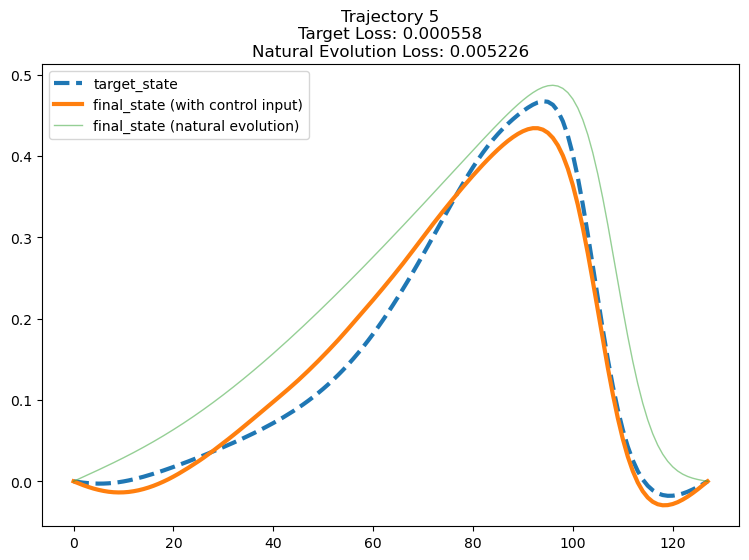

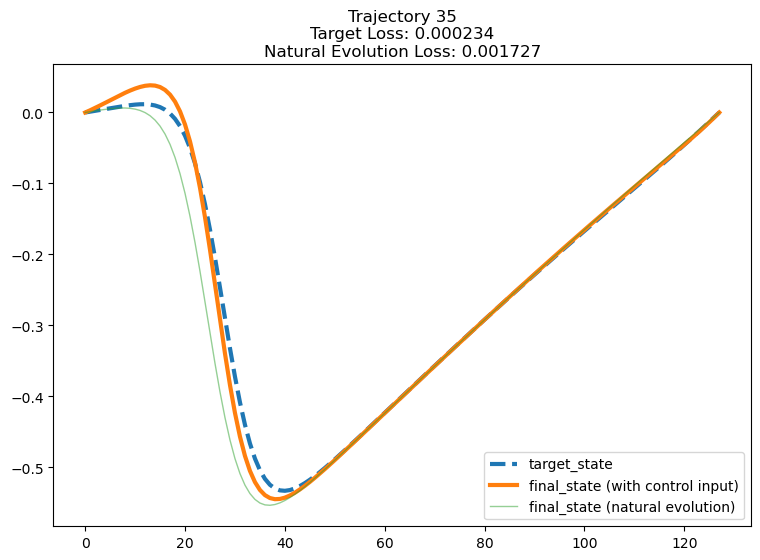

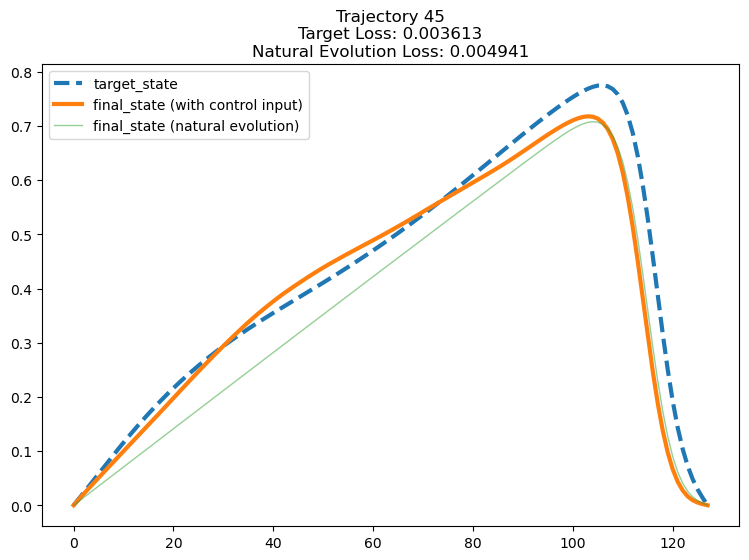

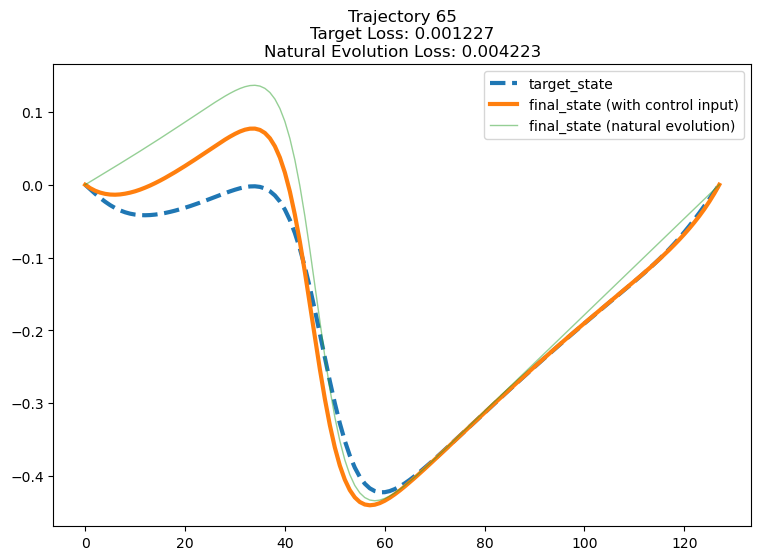

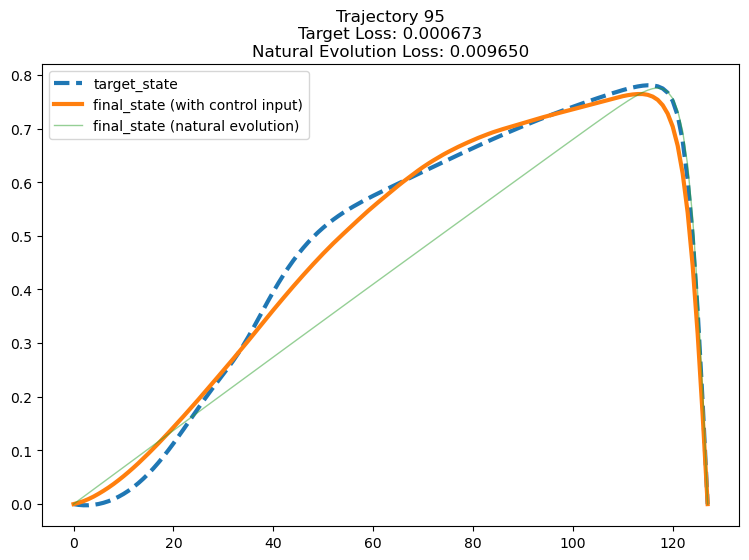

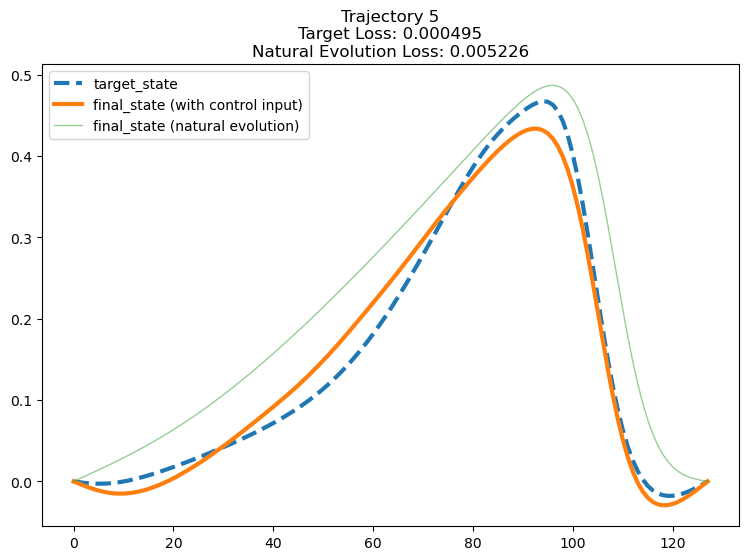

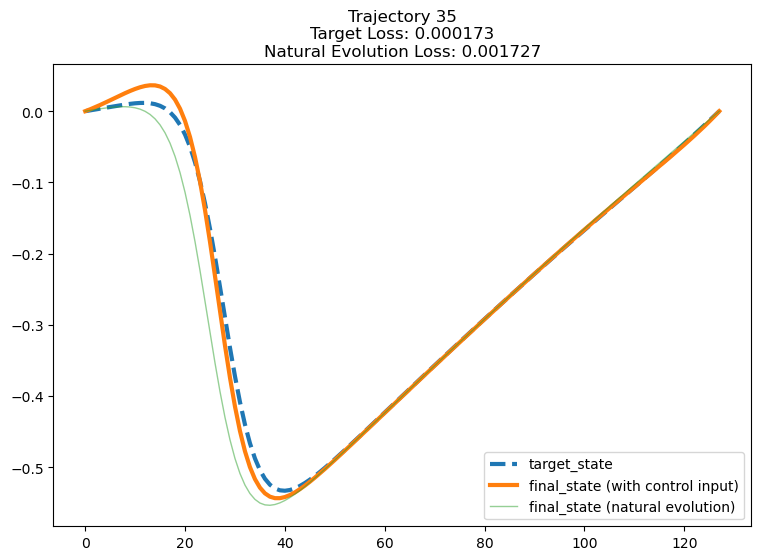

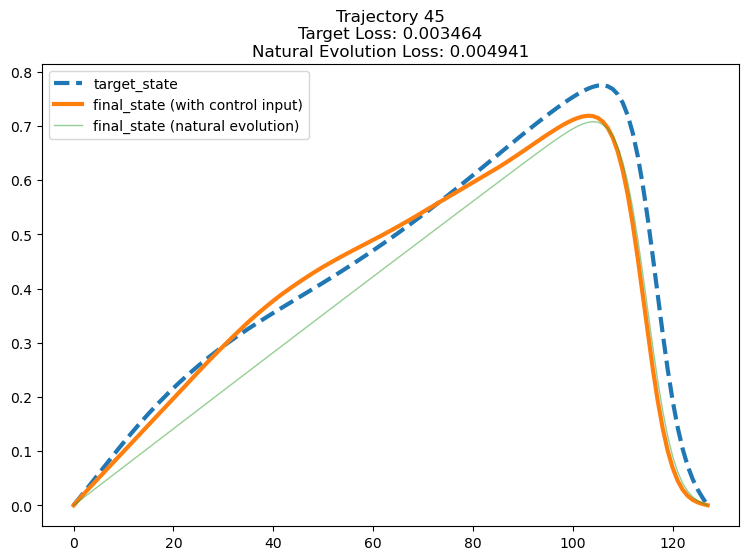

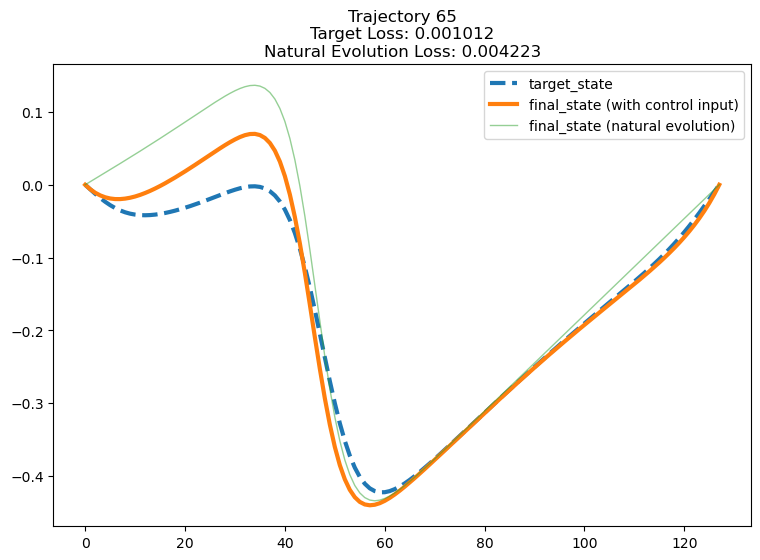

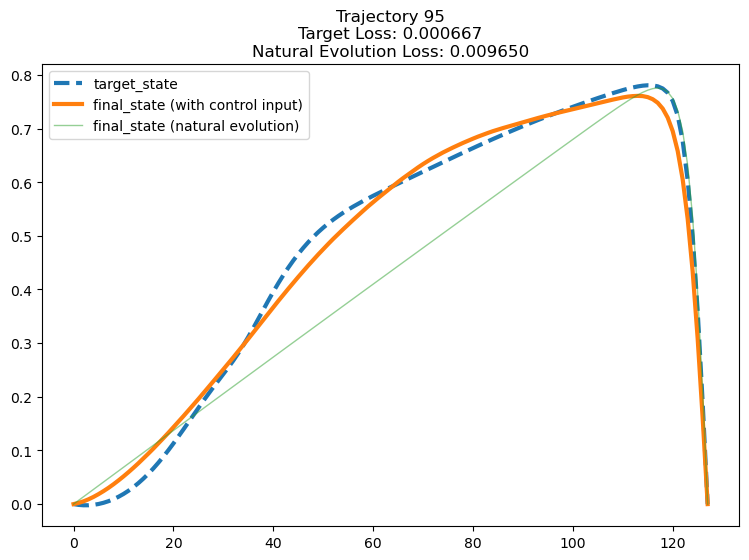

In [11]:
from generate_burgers import burgers_update

test_burgers_data_dict=pickle.load(open('data123\\burgers_100_10_128_1735572331.pkl', 'rb'))


def evolve(model, initial_state, target_state, with_control=True):
    '''
    Return the final state vector given initial state vector, with or without control input.
    If with_control is False, the model will be evaluated without control input.
    '''
    global state_dim, action_dim, dx, dt, device
    assert initial_state.shape == target_state.shape == (state_dim,)
    s=initial_state # (state_dim,), the state vector (original meaning)
    S=np.concatenate((initial_state, target_state, np.array([0]))) # (state_dim*2+1,), the concatenated state vector (with target state and time step)
    for i in range(nt): # Loop over time steps to update the state vector
        if i%t_sample_interval==0: # Update the action every t_sample_interval time steps (every 1000 time steps)
            a = model.select_action(torch.FloatTensor(S).unsqueeze(0).to(device), is_sample=False).cpu().data.numpy().flatten()
        #print(a.shape)
        if with_control: # The normal case
            s=burgers_update(np.array(s),np.array(a),dx,dt)
        else: # If we want to evolve the initial state without any control input. This is a baseline.
            s=burgers_update(np.array(s),0*np.array(a),dx,dt) # Set the control input to 0
        S=np.concatenate((s,target_state,np.array([i//t_sample_interval]))) # Update the concatenated state vector
    return s # Return the final state vector


def plot_state(model, data_dict, traj_index):
    assert traj_index<data_dict['observations'].shape[0], 'traj_index out of range'
    initial_state = data_dict['observations'][traj_index][0] # (state_dim,)
    target_state = data_dict['Y_f'][traj_index] # (state_dim,)
    final_state=evolve(model, initial_state=initial_state, target_state=target_state) # (state_dim,)
    final_state_=evolve(model, initial_state=initial_state, target_state=target_state, with_control=False) # (state_dim,)

    plt.figure(figsize=(9,6))
    #plt.plot(initial_state, label='initial_state')
    plt.plot(target_state, label='target_state', lw=3, linestyle='--')
    plt.plot(final_state, label='final_state (with control input)', lw=3)
    plt.plot(final_state_, label='final_state (natural evolution)', alpha=0.5, lw=1)
    plt.title('Trajectory {}\nTarget Loss: {:.6f}\nNatural Evolution Loss: {:.6f}'.format(
                    traj_index,
                    ((final_state-target_state)**2).mean(),
                    ((final_state_-target_state)**2).mean()))
    plt.legend()
    plt.show()

plot_state(model=bppo, data_dict=test_burgers_data_dict, traj_index=5)
plot_state(model=bppo, data_dict=test_burgers_data_dict, traj_index=35)
plot_state(model=bppo, data_dict=test_burgers_data_dict, traj_index=45)
plot_state(model=bppo, data_dict=test_burgers_data_dict, traj_index=65)
plot_state(model=bppo, data_dict=test_burgers_data_dict, traj_index=95)
plot_state(model=bc, data_dict=test_burgers_data_dict, traj_index=5)
plot_state(model=bc, data_dict=test_burgers_data_dict, traj_index=35)
plot_state(model=bc, data_dict=test_burgers_data_dict, traj_index=45)
plot_state(model=bc, data_dict=test_burgers_data_dict, traj_index=65)
plot_state(model=bc, data_dict=test_burgers_data_dict, traj_index=95)

In [12]:
def evaluate(model, data_dict):
    final_losses=[]
    final_losses_=[]
    for i in tqdm.tqdm(range(len(data_dict['observations'])), desc='Looping over trajectories'):
        initial_state = test_burgers_data_dict['observations'][i][0] # (state_dim,)
        target_state = test_burgers_data_dict['Y_f'][i] # (state_dim,)
        final_state=evolve(model, initial_state, target_state, with_control=True)
        final_state_=evolve(model, initial_state, target_state, with_control=False)
        final_losses.append(np.mean(np.square(final_state-target_state)))
        final_losses_.append(np.mean(np.square(final_state_-target_state)))
    return np.mean(final_losses), np.mean(final_losses_)

evaluate(bppo, test_burgers_data_dict)


Looping over trajectories: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


(0.0009595689737968458, 0.004849128535548501)

In [13]:
evaluate(bc, test_burgers_data_dict)

Looping over trajectories: 100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


(0.0008542936204543267, 0.004849128535548501)